# ABSTRACT
Annotating a large-scale point cloud dataset for tasks like 3D object classification, segmentation, and detection can be time-consuming due to the irregular nature of point clouds. Self-supervised learning, which eliminates the need for manual labeling, presents a hopeful solution to this challenge. [1]
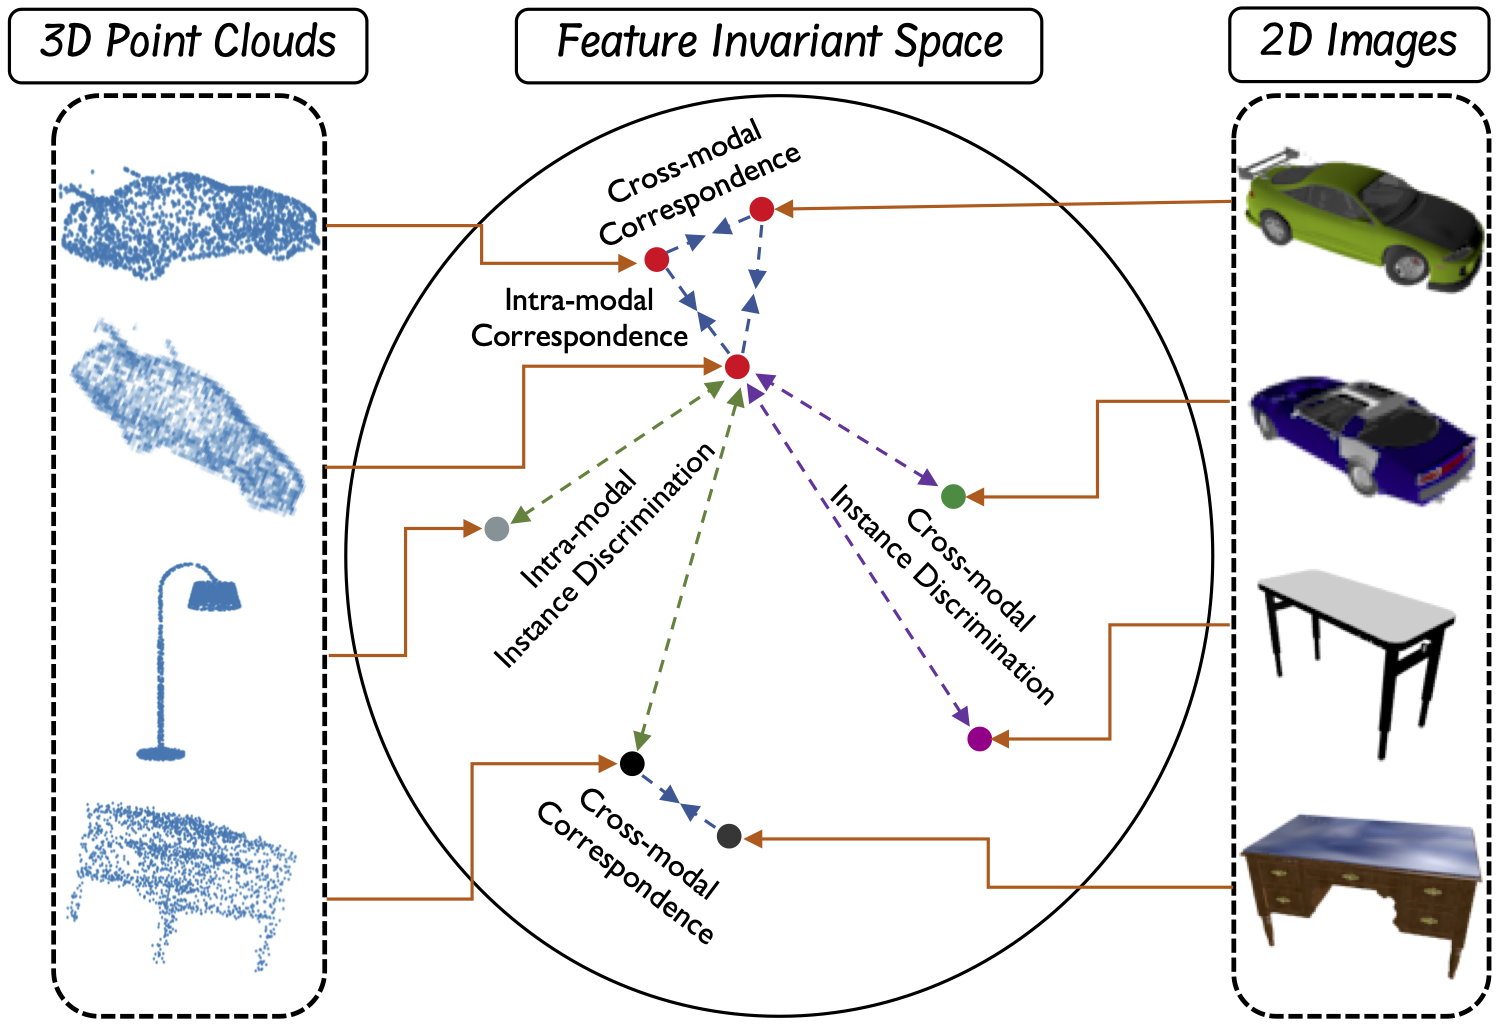

# The method
The code aims to establish the relationship between 3D objects and 2D images in order to effectively learn transferable point cloud representations. We provide a reimplementation of the methods in the reference paper in PyTorch Lightning which is a high-level library for PyTorch and allows to easily build, train, and evaluate complex deep learning models. It provides a convenient and modular structure for PyTorch code, making it easier to scale, debug, and reuse code. 

The concept is to embeds augmented versions of the same point cloud close together in the feature space while maintaining their correspondence with the original 3D point cloud and its rendered 2D image; in our approach we have tested  other combinations of models to extract feature from sample.


# Our Work

In this project we suggest a reimplementation of CrossPoint, a straightforward cross-modal contrastive learning technique, to learn transferable 3D point cloud representations. It allows for a match between 3D objects and 2D images by maximizing consistency in the invariant space between point clouds and the related rendered 2D image, while encouraging invariance to transformations in the point cloud modality.

Being more precise we added to the original paper the Naive point Cloud transformer presented in Meng-Hao Guo et al. [2] with some edits to the original architecture of the mode;
For the images we added the VisionTransformer model Alexey Dosovitskiy et al. [4].
For a summary:
we reimplemented in pytorch Lightning the original paper using their code
we explored others combination of model, this is the complete list:
DGCNN+ResNet (Reference paper)
Naive Point Cloud Transformer + Vision Transformer (Transformer-based crosspoint)
Naive Point Cloud Transformer + ResNet 
DGCNN + VisionTransformer

we worked on the classification task, discarding the segmentation task due to the hardware available for training.


### DRIVE CONNECTION

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


### INSTALL DEPENDECIES

In [ ]:
!pip install pytorch_lightning --quiet
!pip install lightly --quiet
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.6/530.6 KB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.2 MB/s eta 0:00:00


### Requirements per pointbert (forget about this 😞)


### IMPORT

In [ ]:
import argparse
import pytorch_lightning as pl
import torch
from torchvision import transforms
import numpy as np
import wandb
from lightly.loss.ntx_ent_loss import NTXentLoss
from torch.utils.data import DataLoader
#from datasets.data import ShapeNetRender, ModelNet40SVM
from drive.MyDrive.CrossPoint_Sapienza_NN_2023.util import IOStream, AverageMeter
import torch.nn as nn
import torch.nn.functional as F

#from models.dgcnn import DGCNN, ResNet, DGCNN_partseg
from torchvision.models import resnet50, resnet18
from torchvision.models import vit_l_16
#from models/pointbert/Point-BERT/models import Point_Bert

#path management
import sys

#cache pyton management
import imp
#for _init_() function to save checkpoints
import os

from sklearn.svm import SVC

### CONSTANTS
❗❗❗❗ Change the name of the experiment when you do a training with different combination of models 



In [ ]:
#COSTANTI
exp_name = 'PCT+VisionTransformer' # Name of the experiment
model_point = 'pct' # Model to use, [dgcnn, pct]
model_img = 'visiontransformer' # Model to use for images feature extraction, [resnet, visiontrasformer]
batch_size = 5 # (Size of training batch)
val_batch_size = 2 # (Size of validation batch)
test_batch_size = 2 # (Size of testing batch)
epochs = 100 # number of episode to train
start_epoch = 0  # number of episode to train
use_sgd = False # Use SGD
lr = 0.001 # learning rate (default: 0.001, 0.1 if using sgd)
momentum = 0.9 # SGD momentum (default: 0.9)
no_cuda = False # enables CUDA training
seed = 1 # random seed (default: 1)'
evalu = False # evaluate the model
num_points = 2048 # num of points to use
dropout = 0.5 # dropout rate
emb_dims = 1024 # Dimension of embeddings
k = 20 # Num of nearest neighbors to use
resume = False  # resume from checkpoint
model_path = '' # Pretrained point model path.   #/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints/nomeexp/
#model_img_path = '' # Pretrained img model path.   #/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints/nomeexp/
save_freq = 2 # save frequency
print_freq = 50 # print frequency
enable_wandb = True # enables wandb
spct_model_path = "/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/models/naive_pct.t7"

#use a dictionary
args = {
    'exp_name': exp_name,
    'model_point': model_point,
    'model_img': model_img,
    'batch_size': batch_size,
    'val_batch_size' : val_batch_size,
    'test_batch_size': test_batch_size,
    'epochs': epochs,
    'start_epoch': start_epoch,
    'use_sgd': use_sgd,
    'lr': lr,
    'momentum': momentum,
    'no_cuda': no_cuda,
    'seed': seed,
    'evalu': evalu,
    'num_points': num_points,
    'dropout': dropout,
    'emb_dims': emb_dims,
    'k': k,
    'resume': resume,
    'model_path': model_path,
    #'model_img_path': model_img_path,
    'save_freq': save_freq,
    'print_freq': print_freq,
    'enable_wandb': enable_wandb,
    'spct_model_path': spct_model_path
}




### FUNCTIONS (DGCNN) ⏩⏩⏩

In [ ]:
def check_checkpoint_folders(): 
  if not os.path.exists('/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints'):
        os.makedirs('/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints')
  if not os.path.exists('/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints/'+ args['exp_name']):
      os.makedirs('/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints/'+ args['exp_name'])
  if not os.path.exists('/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints/'+args['exp_name']+'/'+'models'):
      os.makedirs('/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints/'+args['exp_name']+'/'+'models')

def knn(x, k):
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
 
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (batch_size, num_points, k)
    return idx


def get_graph_feature(x, k=20, idx=None):
    # SPATIAL TRANSFORM
    # Application of the transformation of a point cloud in a graph considering the k neighbour 
    # Then conversion into canonical pose (from PointNet to normalize point cloud)
    # -----------------------------------

    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    if idx is None:
        idx = knn(x, k=k)   # (batch_size, num_points, k)

    
    device = torch.cuda.current_device()

    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points
    idx = idx.to(device)
    idx = idx + idx_base

    idx = idx.view(-1)
 
    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    #batch_size = batch_size.to(device)
    #num_points = num_points.to(device)

    x = x.to(device)
    idx = idx.to(device)

    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims) 
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    # Conversion into a canonical pose ()
    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous() 
  
    return feature


### DGCNN --- CHECK THE MODEL ARCHITECTURE🔗
In this project we provide a translation in Pytoch Lightning of the DGCNN [3] model (Dynamic Graph Convolutional Neural Networks) which can be used as a feature extractor in various computer vision tasks, such as object recognition, semantic segmentation, and image classification. In this role, the DGCNN network is trained on a large dataset to learn high-level features that are representative of the objects in the images. The extracted features can be used for a variety of tasks, such as object recognition, semantic segmentation, and image classification (as in our case).



In [ ]:
class DGCNN(pl.LightningModule):
    def __init__(self, args, cls = -1) -> None:
        super(DGCNN,self).__init__()
        self.k = args['k']

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm1d(args['emb_dims'])

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),self.bn1, nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),self.bn2,nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 128, kernel_size=1, bias=False),self.bn3,nn.LeakyReLU(negative_slope=0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(128*2, 256, kernel_size=1, bias=False), self.bn4, nn.LeakyReLU(negative_slope=0.2))
        self.conv5 = nn.Sequential(nn.Conv1d(512, args['emb_dims'], kernel_size=1, bias=False), self.bn5, nn.LeakyReLU(negative_slope=0.2))

        if cls != -1:
            self.linear1 = nn.Linear(args['emb_dims']*2, 512, bias=False)
            self.bn6 = nn.BatchNorm1d(512)
            self.dp1 = nn.Dropout(p=args['dropout'])
            self.linear2 = nn.Linear(512, 256)
            self.bn7 = nn.BatchNorm1d(256)
            self.dp2 = nn.Dropout(p=args['dropout'])
            self.linear3 = nn.Linear(256, output_channels)
        
        self.cls = cls

        self.inv_head = nn.Sequential(
              nn.Linear(args['emb_dims'] * 2, args['emb_dims']),
              nn.BatchNorm1d(args['emb_dims']),
              nn.ReLU(inplace=True),
              nn.Linear(args['emb_dims'], 256)
          )

    def forward(self, x):
        batch_size = x.size(0)
        # SPATIAL TRANSFORMATION
        x = get_graph_feature(x, k=self.k)
        x = self.conv1(x)
        x1 = x.max(dim=-1, keepdim=False)[0]


        x = get_graph_feature(x1, k=self.k)
        x = self.conv2(x)
        x2 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x2, k=self.k)
        x = self.conv3(x)
        x3 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x3, k=self.k)
        x = self.conv4(x)
        x4 = x.max(dim=-1, keepdim=False)[0]

        x = torch.cat((x1, x2, x3, x4), dim=1)


        x = self.conv5(x)
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1)
        x = torch.cat((x1, x2), 1)

        
        feat = x
        if self.cls != -1:
            x = F.leaky_relu(self.bn6(self.linear1(x)), negative_slope=0.2)
            x = self.dp1(x)
            x = F.leaky_relu(self.bn7(self.linear2(x)), negative_slope=0.2)
            x = self.dp2(x)
            x = self.linear3(x)
        
        inv_feat = self.inv_head(feat)
        

        
        return x, inv_feat, feat 



### RESNET

In [ ]:
class ResNet(pl.LightningModule):
    def __init__(self, model, feat_dim = 2048):
        super(ResNet, self).__init__()
        self.resnet = model
        self.resnet.fc = nn.Identity()
        
        self.inv_head = nn.Sequential(
                            nn.Linear(feat_dim, 512, bias = False),
                            nn.BatchNorm1d(512),
                            nn.ReLU(inplace=True),
                            nn.Linear(512, 256, bias = False)
                            ) 
        
    def forward(self, x):
        x = self.resnet(x)
        #print("SHAPE DI X in RESNET ---->",x.shape) # (batchsize x 2048)
        x = self.inv_head(x)
        
        return x

### VISION TRANSFORMER 🎉🎉🎉
On the other side, in addition of ResNet [5] as in the paper,  we implement a Vision Transformer model as feature extractor for the rendered 2D images, however doing a comparison of the performances using either one or the other.
In a Vision Transformer, the image is first divided into a set of overlapping patches, and the features of each patch are then fed into the Transformer as individual tokens. The Transformer then processes these features using its self-attention mechanism, allowing it to capture the relationships between the patches and learn a representation of the entire image. The output of the Transformer is then processed by additional layers to make predictions for tasks such as image classification, object detection, and segmentation.


In [ ]:
import torchvision.models as models
class VisionTransformer(pl.LightningModule):
    def __init__(self, model, feat_dim = 1000):
        super(VisionTransformer, self).__init__()
        self.vision_transformer = model

        for param in self.vision_transformer.parameters():
            param.requires_grad = False

        self.inv_head = nn.Sequential(
            nn.Linear(feat_dim, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256, bias=False)
        )
        
    def forward(self, x):
        x = self.vision_transformer(x) #get output of hidden states
        #print("SHAPE DI X in ViT ---->",x.shape) # (batchsize, numclasses) -> (2,1000)
        #x = x[:, 0, :]
        x = self.inv_head(x)
        
        return x

### PointCloudTransformer (Naive) 🙈
PCT is a deep learning architecture that processes point clouds using the Transformer architecture;                 the Transformer allows the model to learn global relationships between points in the point cloud by using self-attention mechanisms.
In a Point Cloud Transformer model, each point in the point cloud is represented as a feature vector, and the Transformer processes these feature vectors to generate a compact, dense representation of the entire point cloud. This compact representation can then be used for tasks such as object classification, segmentation … 
In this project we use a naive version of this model, called “naive PCT” which differs from the original one because it typically involves directly applying the Transformer architecture to the point cloud data without any additional pre-processing or modifications. In a naive PCT model, each point in the point cloud is treated as an individual unit, and the Transformer processes these units to generate a compact representation of the entire point cloud.


In [ ]:
import math
def messingWithKeys():
  state_dict = torch.load(args['spct_model_path'])
  point_model = Pct()

  new_state_dict = {}
  not_desired_keys = ["module.cls.linear1.weight", "module.cls.linear2.weight", "module.cls.linear2.bias", "module.cls.bn1.weight", "module.cls.bn1.bias", "module.cls.bn1.running_mean", "module.cls.bn1.running_var", "module.cls.bn1.num_batches_tracked", "module.cls.bn2.weight", "module.cls.bn2.bias", "module.cls.bn2.running_mean", "module.cls.bn2.running_var", "module.cls.bn2.num_batches_tracked"]
  for k, v in state_dict.items():
      if k not in not_desired_keys:
        new_k = k.replace("module.encoder.", "")
        new_state_dict[new_k] = v

  point_model.load_state_dict(new_state_dict)
  return point_model

class Embedding(nn.Module):
    """
    Input Embedding layer which consist of 2 stacked LBR layer.
    """

    def __init__(self, in_channels=3, out_channels=128):
        super(Embedding, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=False)

        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
    
    def forward(self, x):
        """
        Input
            x: [B, in_channels, N]
        
        Output
            x: [B, out_channels, N]
        """
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x


class SA(nn.Module):
    """
    Self Attention module.
    """

    def __init__(self, channels):
        super(SA, self).__init__()

        self.da = channels // 4

        self.q_conv = nn.Conv1d(channels, channels // 4, 1, bias=False)
        self.k_conv = nn.Conv1d(channels, channels // 4, 1, bias=False)
        self.q_conv.weight = self.k_conv.weight
        self.v_conv = nn.Conv1d(channels, channels, 1)
        
        self.trans_conv = nn.Conv1d(channels, channels, 1)
        self.after_norm = nn.BatchNorm1d(channels)
        
        self.act = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        """
        Input
            x: [B, de, N]
        
        Output
            x: [B, de, N]
        """
        # compute query, key and value matrix
        x_q = self.q_conv(x).permute(0, 2, 1)  # [B, N, da]
        x_k = self.k_conv(x)                   # [B, da, N]        
        x_v = self.v_conv(x)                   # [B, de, N]

        # compute attention map and scale, the sorfmax
        energy = torch.bmm(x_q, x_k) / (math.sqrt(self.da))   # [B, N, N]
        attention = self.softmax(energy)                      # [B, N, N]

        # weighted sum
        x_s = torch.bmm(x_v, attention)  # [B, de, N]
        x_s = self.act(self.after_norm(self.trans_conv(x_s)))
        
        # residual
        x = x + x_s

        return x

class Pct(pl.LightningModule):
    def __init__(self,args):
        super().__init__()
        self.args = args 

        self.embedding = Embedding(3, 128)

        self.sa1 = SA(128)
        self.sa2 = SA(128)
        self.sa3 = SA(128)
        self.sa4 = SA(128)

        self.linear = nn.Sequential(
            nn.Conv1d(512, 1024, kernel_size=1, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.inv_head = nn.Sequential(
              nn.Linear(args['emb_dims'] * 2, args['emb_dims']),
              nn.BatchNorm1d(args['emb_dims']),
              nn.ReLU(inplace=True),
              nn.Linear(args['emb_dims'], 256)
          )

       
    def forward(self, x):
        batch_size = x.size(0)

        x = self.embedding(x) #x shape->torch.Size([2bs, 3, 2048])
        
        x1 = self.sa1(x) #x1 shape->torch.Size([2bs, 128, 2048])
        x2 = self.sa2(x1) #x2 shape->torch.Size([2bs, 128, 2048])
        x3 = self.sa3(x2) #x3 shape->torch.Size([2bs, 128, 2048])
        x4 = self.sa4(x3) #x4 shape->torch.Size([2bs, 128, 2048])
        x = torch.cat([x1, x2, x3, x4], dim=1) #x shape after cat->torch.Size([10, 512, 2048])

        x = self.linear(x) #x shape after linear->torch.Size([10, 1024, 2048])
    

        # x = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1) # 2bs,1024
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1) # 2bs,1024
        x = torch.cat((x1, x2), 1) # 2bs,2048
        feat = x
        inv_feat = self.inv_head(feat) # torch.Size([2bs, 256])

        x_max = torch.max(x, dim=-1)[0]
        x_mean = torch.mean(x, dim=-1)

        return inv_feat, x_max, x_mean, feat


### ⚡️⚡️⚡️⚡️⚡️⚡️⚡️⚡️ CROSSPOINT LIGHTNING (the lightning module). ⚡️⚡️⚡️⚡️⚡️⚡️⚡️⚡️
ShapeNetRedner in dataset/data.py
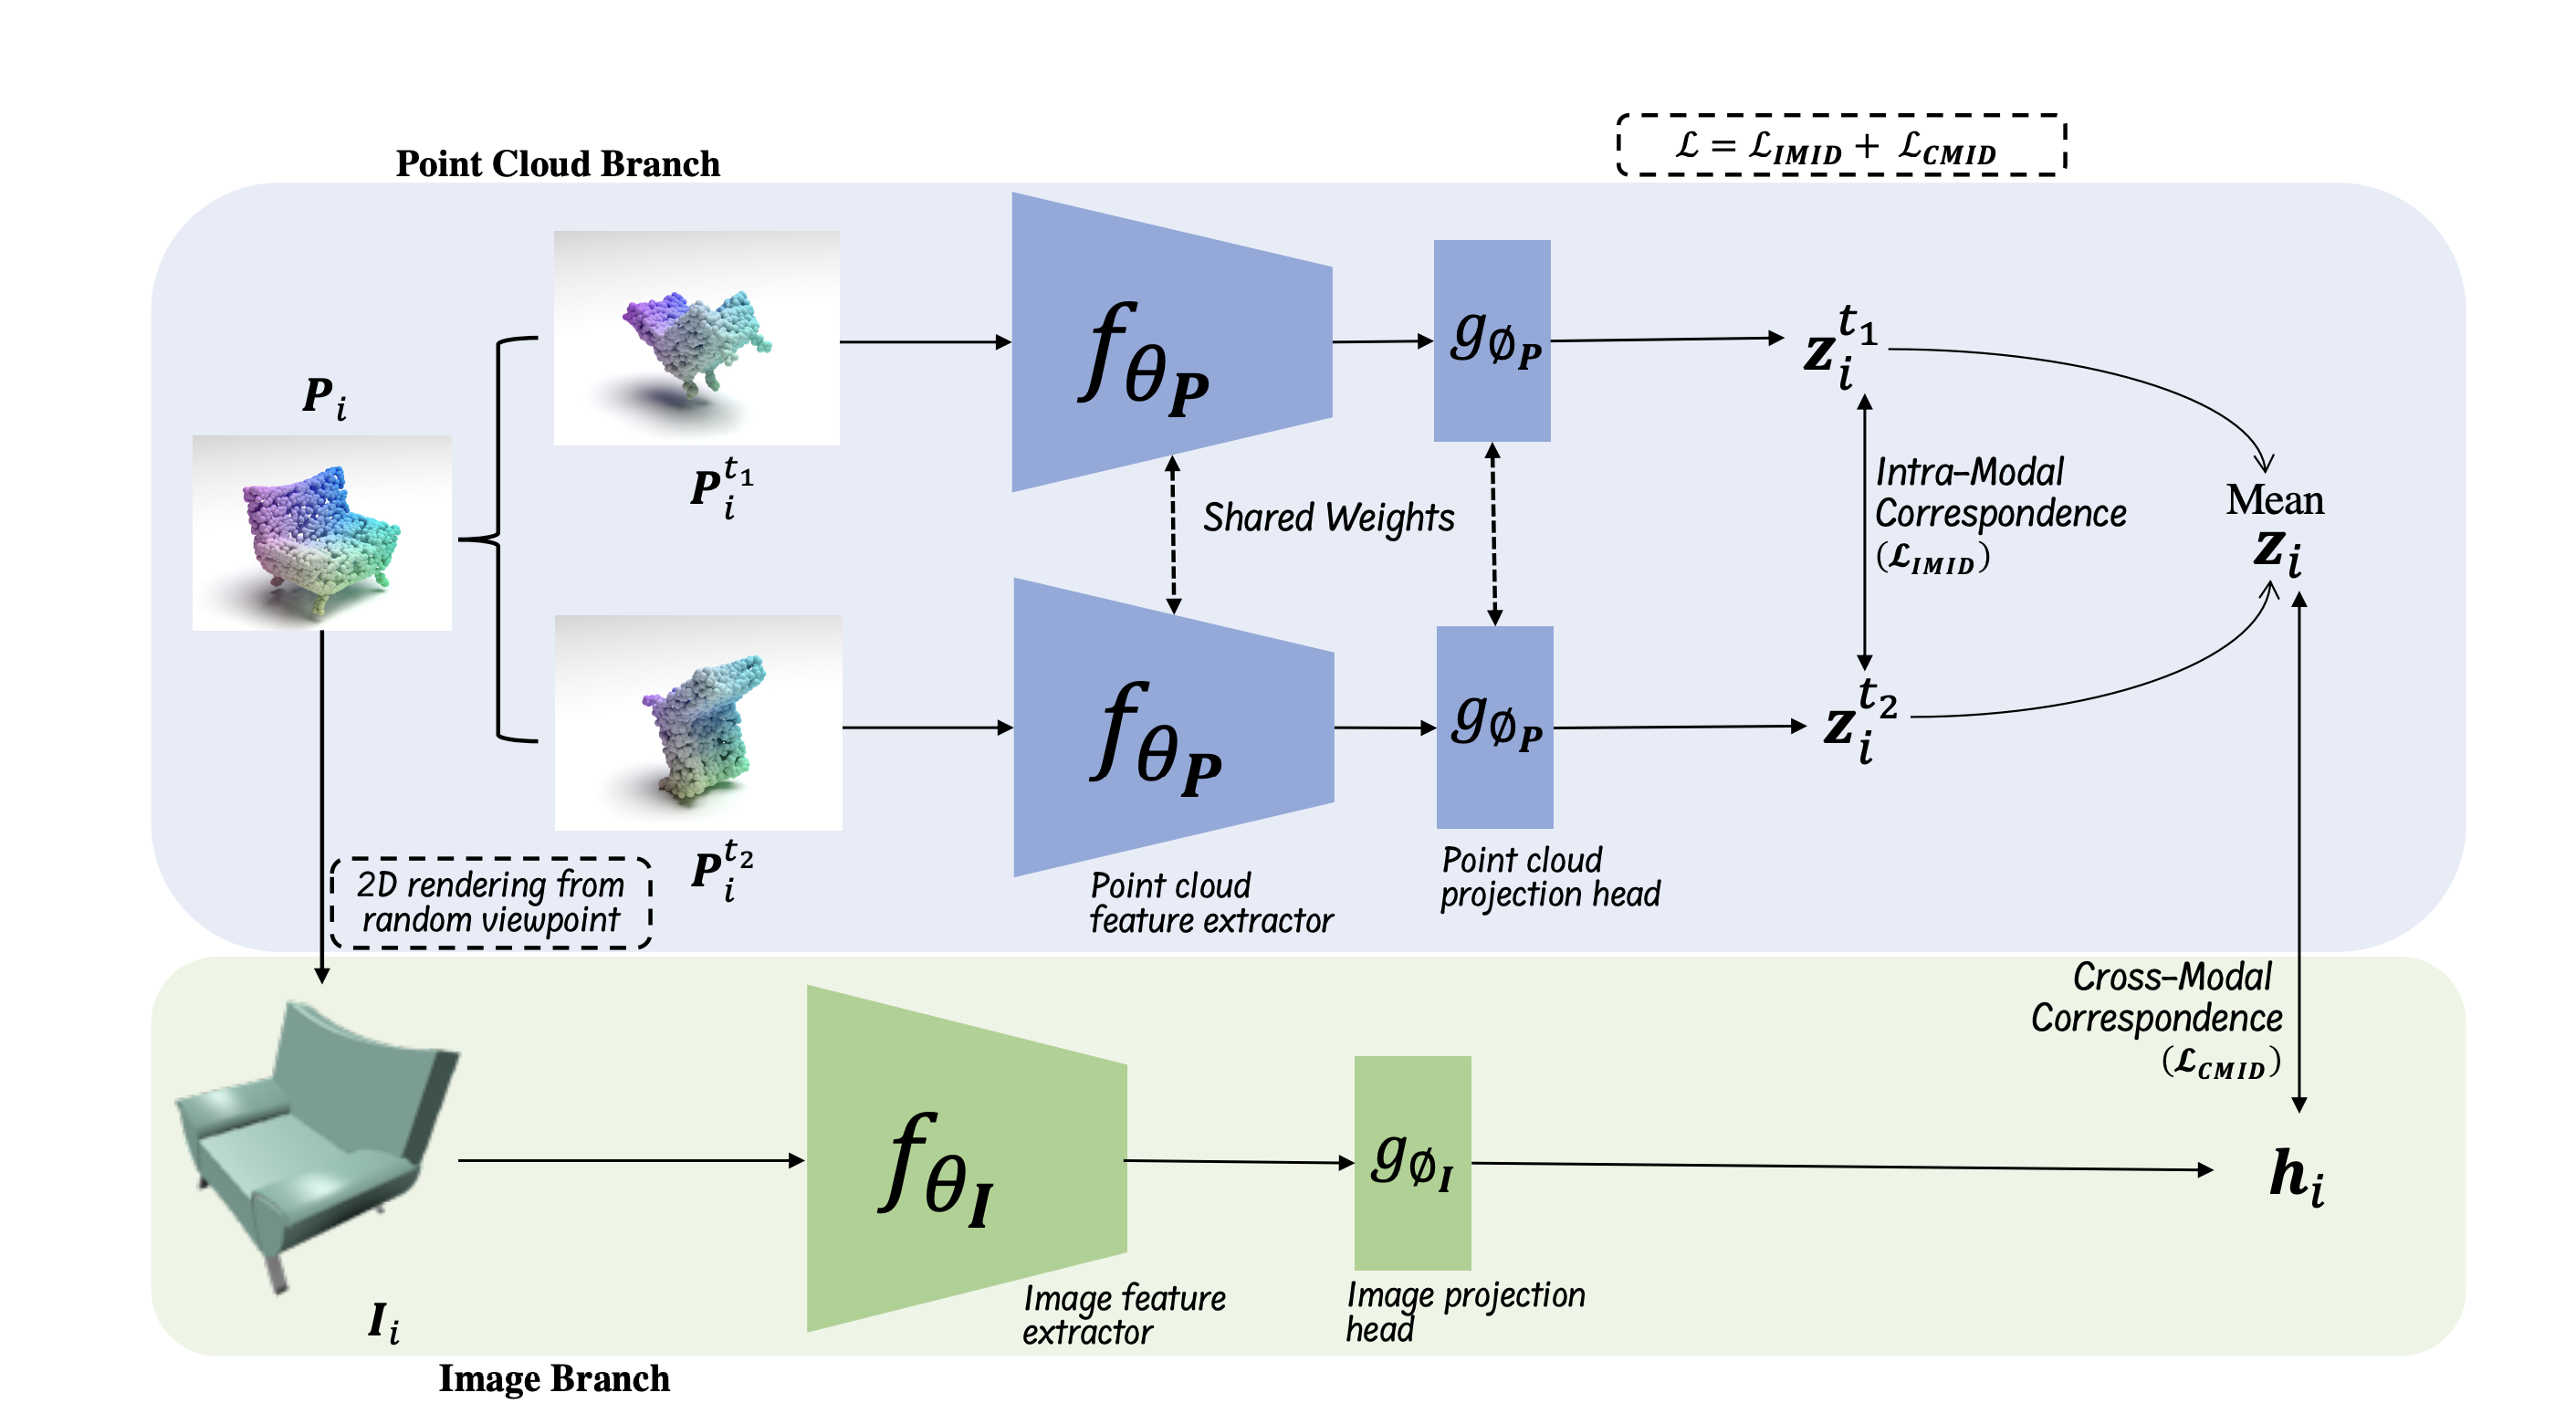

In [ ]:
class CrosspointLightning (pl.LightningModule):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.best_acc = 0
        
        if self.args['enable_wandb'] == True:
          self.wandb_log = {}


        print("Init CrosspointLightning v4")
        
        
        # ------------
        # models
        # ------------
        if args['model_point'] == 'dgcnn':
            self.point_model = DGCNN(args) # .to(device) ?
        elif args['model_point'] == 'pct':
            #import spct from path
            #self.point_model = messingWithKeys()
            #import for train pct
            self.point_model = Pct(args)
        elif args['model_point'] == 'pointbert':
           raise Exception("@Not implemented PointBert")            
        else:
            raise Exception("Not implemented")

        if args['model_img'] == 'resnet':
            self.img_model = ResNet(resnet50(), feat_dim = 2048) 
        elif args['model_img'] == 'visiontransformer':
            self.img_model = VisionTransformer(vit_l_16(), feat_dim = 1000) 
        else:
            raise Exception("Not implemented")

        
        self.criterion = NTXentLoss(temperature = 0.1)

        if args['enable_wandb'] == True:
            wandb.watch(self.point_model)

        if args['resume']:
            # self.point_model = self.point_model.load_state_dict(torch.load(args['model_point_path']))
            # self.img_model = self.img_model.load_state_dict(torch.load(args['model_img_path']))
            model.load_state_dict(torch.load(args['model_path']))
            print("Model Loaded !!")

    def on_train_epoch_start(self):
        print("Starting epoch ->",self.current_epoch," (training)")
        self.train_losses = AverageMeter()
        self.train_imid_losses = AverageMeter()
        self.train_cmid_losses = AverageMeter()

        
        self.point_model.train()
        self.img_model.train()

    def on_train_epoch_end(self):
      if self.args['enable_wandb'] == True:
          self.wandb_log['Train Loss'] = self.train_losses.avg
          self.wandb_log['Train IMID Loss'] = self.train_imid_losses.avg
          self.wandb_log['Train CMID Loss'] = self.train_cmid_losses.avg
      print("Ending epoch ->",self.current_epoch," (training)")     
      outstr = 'Training %d, loss: %.6f' % (self.current_epoch, self.train_losses.avg)
      self.custom_validation_step(self.args)
      io.cprint(outstr)  
        
    def training_step(self, batch, batch_idx):
        (data_t1 ,data_t2), imgs = batch
        batch_size = data_t1.size()[0]

        if args['model_point'] == 'dgcnn' or args['model_point'] == 'dgcnn_seg':
            data = torch.cat((data_t1, data_t2)) #data_t1,data_t2 shape -> [bs,2048,3]
            #data shape -> [2bs,2048,3]
            data = data.transpose(2, 1).contiguous() #data shape after transpose-> [2bs,3,2048]
            _, point_feats, _ = self.point_model(data) #point_feats shape-> [2bs,256]
            point_t1_feats = point_feats[:batch_size, :] #point_t1_feats shape-> [bs,256]
            point_t2_feats = point_feats[batch_size: , :] #point_t2_feats shape-> [bs,256]

            loss_imid = self.criterion(point_t1_feats, point_t2_feats)        
            point_feats = torch.stack([point_t1_feats,point_t2_feats]).mean(dim=0) #point_feats after mean shape-> [bs,256]
        elif args['model_point'] == 'pct':
            data = torch.cat((data_t1, data_t2)) #data shape -> [2bs,2048,3]
            data = data.transpose(2, 1).contiguous() #data shape after transpose-> [2bs,3,2048]
            embbedded_x, _, _, _  = self.point_model(data) 
            point_t1_feats = embbedded_x[:batch_size, :]
            point_t2_feats = embbedded_x[batch_size: , :]
            loss_imid = self.criterion(point_t1_feats, point_t2_feats)        
            point_feats = torch.stack([point_t1_feats,point_t2_feats]).mean(dim=0)
        else:
            raise Exception("Not implemented")
        
        img_feats = self.img_model(imgs) #imgs_feats shape->[5,256]
        
        loss_cmid = self.criterion(point_feats, img_feats)

        total_loss = loss_imid + loss_cmid
        
        if self.args['enable_wandb'] == True:
          self.wandb_log['Total train loss'+args['exp_name']] = total_loss
          self.wandb_log['Imid loss'+args['exp_name']] = loss_imid
          self.wandb_log['Cmid loss'+args['exp_name']] = loss_cmid
          wandb.log(self.wandb_log)

        if batch_idx % self.args['print_freq'] == 0:
                print('Epoch (%d), Batch(%d/%d), loss: %.6f, imid loss: %.6f, cmid loss: %.6f ' % (self.current_epoch, batch_idx, self.args['train_loader_len'], total_loss, loss_imid, loss_cmid))
        
        self.train_losses.update(total_loss.item(), batch_size)
        self.train_imid_losses.update(loss_imid.item(), batch_size)
        self.train_cmid_losses.update(loss_cmid.item(), batch_size)
        
        return total_loss
              
    def forward(self, x):
        return x

    def custom_validation_step(self,args):
      print("Starting epoch ",self.current_epoch," (validation_epoch_start)")
      self.train_val_loader = DataLoader(ModelNet40SVM(partition='train', num_points=1024),num_workers=12, batch_size=5, shuffle=True)
      self.test_val_loader = DataLoader(ModelNet40SVM(partition='test', num_points=1024),num_workers=12, batch_size=2, shuffle=True)

      feats_train = []
      labels_train = []

      self.point_model.eval()

      print("Starting epoch ",self.current_epoch," (validation_step)")
      if torch.cuda.is_available():
        device = torch.device("cuda")
      else: device = torch.device('cpu')

      for i, (data, label) in enumerate(self.train_val_loader):
            labels = list(map(lambda x: x[0],label.numpy().tolist()))
            data = data.permute(0, 2, 1)
            data = data.to(device)
            
            with torch.no_grad():
                if self.args['model_point'] == 'dgcnn':
                  feats = self.point_model(data)[2]
                elif self.args['model_point'] == 'pct':
                  feats = self.point_model(data)[3]
                else:
                  raise ("Not implemented")

            feats = feats.detach().cpu().numpy()
            for feat in feats:
                feats_train.append(feat)
            labels_train += labels

      feats_train = np.array(feats_train)
      labels_train = np.array(labels_train)

      feats_test = []
      labels_test = []

      for i, (data, label) in enumerate(self.test_val_loader):
          labels = list(map(lambda x: x[0],label.numpy().tolist()))
          data = data.permute(0, 2, 1)
          data = data.to(device)

          with torch.no_grad():
              if self.args['model_point'] == 'dgcnn':
                feats = self.point_model(data)[2]
              elif self.args['model_point'] == 'pct':
                feats = self.point_model(data)[3]
              else:
                  raise ("Not implemented")

          feats = feats.detach().cpu().numpy()
          for feat in feats:
              feats_test.append(feat)
          labels_test += labels

      feats_test = np.array(feats_test)
      labels_test = np.array(labels_test)
      
      model_tl = SVC(C = 0.1, kernel ='linear')
      model_tl.fit(feats_train, labels_train)
      test_accuracy = model_tl.score(feats_test, labels_test)

      if args['enable_wandb'] == True:
        self.wandb_log['Linear Accuracy'] = test_accuracy
      
      print(f"Linear Accuracy : {test_accuracy}")
      
      if test_accuracy > self.best_acc:
          self.best_acc = test_accuracy
          print('==> NEW RECORD on accuracy on epoch ',self.current_epoch,' --- Accuracy = ',test_accuracy,' ----> SAVING Best Model...')
          file_name = 'best_model'+self.args['model_point']+'.pth'
          save_file = os.path.join('/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints/' + self.args['exp_name'] + '/models/', file_name.format(epoch=self.current_epoch) )
          torch.save(self.point_model.state_dict(), save_file)
          

          file_name = 'best_model'+self.args['model_img']+'.pth'
          save_img_model_file = os.path.join('/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints/' + self.args['exp_name'] + '/models/', 'img_model_best'+self.args['model_img']+'.pth' )
          torch.save(self.img_model.state_dict(), save_img_model_file)

      if self.current_epoch % self.args['save_freq'] == 0:
          print('==> Saving for frequency...')
          save_file = os.path.join(f'/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints/{self.args["exp_name"]}/models/','ckpt_epoch_{'+str(self.current_epoch)+'}'+self.args['model_point']+'.pth'.format(epoch=self.current_epoch))
          torch.save(self.point_model.state_dict(), save_file)

      if args['enable_wandb'] == True:
        wandb.log(self.wandb_log)

      return {'val_acc': test_accuracy}


    def configure_optimizers(self):
        parameters = list(self.point_model.parameters()) + list(self.img_model.parameters())
        
        # ------------
        # optimizer
        # ------------
        if args['use_sgd']:
            print("Use SGD")
            optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'], weight_decay=1e-6)
        else:
            print("Use Adam")
            optimizer = torch.optim.Adam(parameters, lr=args['lr'], weight_decay=1e-6)
        
        # ------------
        # scheduler
        # ------------
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args['epochs'], eta_min=0, last_epoch=-1)


        return [optimizer], [lr_scheduler]

### THE TRAIN FUNCTION 🎉🎉🎉🎉
The dataset used for pre-training the model is ShapeNet which originally consists of more than 50,000 CAD models from 55 categories but due to hardware reasons we reduce the dataset to only one class that is “airplanes” .

So the model is trained on learning feature only for this class in particular but despite this we got some decent results on the final classification. 

For a given point cloud, we randomly select a 2D image out of all the rendered images(ShapeNet Rendering), which is captured from an arbitrary viewpoint.


In [ ]:
def train(args,io):

    if args['enable_wandb'] == True:
        print('Wandb Enabled')
        wandb.init(project="CrossPoint", name=args['exp_name'])

    
    # ------------
    # data
    # ------------
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    train_loader = DataLoader(ShapeNetRender(transform, n_imgs = 2), num_workers=12, batch_size=args['batch_size'], shuffle=True, drop_last=True)
    args['train_loader_len'] = len(train_loader)
    # device = torch.device("cuda" if args.cuda else "cpu")
     
    # ------------
    # model
    # ------------
    model = CrosspointLightning(args)
    
    # ------------
    # training
    # ------------
    parsed_args = argparse.Namespace(**args)
    
    trainer = pl.Trainer.from_argparse_args(parsed_args,max_epochs=args['epochs'],accelerator='gpu') #??? devices = 1 ???
    
    trainer.fit(model, train_loader)

### 🚀🚀🚀🚀 THE MAIN FUNCTION 🚀🚀🚀🚀

In [ ]:
check_checkpoint_folders()
torch.set_float32_matmul_precision('medium')
io = IOStream('/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/checkpoints/' + args['exp_name'] + '/run.log')
io.cprint(str(args))
args['cuda'] = not args['no_cuda'] and torch.cuda.is_available()
torch.manual_seed(args['seed'])
if args['cuda']:
    io.cprint(
        'Using GPU : ' + str(torch.cuda.current_device()) + ' from ' + str(torch.cuda.device_count()) + ' devices')
    torch.cuda.manual_seed(args['seed'])
else:
    io.cprint('Using CPU')

if args['model_point'] == 'pointbert':
  sys.path.append('content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/models/Point_BERT/models')
  from drive.MyDrive.CrossPoint_Sapienza_NN_2023.models.Point_BERT.models import Point_BERT

sys.path.append('/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/datasets')
from drive.MyDrive.CrossPoint_Sapienza_NN_2023.datasets.data import ShapeNetRender, ModelNet40SVM
#sys.path.append('content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/models/Point_BERT') # forse è /models/Point_BERT/models


# ------------
# training or testing
# ------------ 
if not args['evalu']:
    train(args, io)

{'exp_name': 'PCT+VisionTransformer', 'model_point': 'pct', 'model_img': 'visiontransformer', 'batch_size': 5, 'val_batch_size': 2, 'test_batch_size': 2, 'epochs': 100, 'start_epoch': 0, 'use_sgd': False, 'lr': 0.001, 'momentum': 0.9, 'no_cuda': False, 'seed': 1, 'evalu': False, 'num_points': 2048, 'dropout': 0.5, 'emb_dims': 1024, 'k': 20, 'resume': False, 'model_path': '', 'save_freq': 2, 'print_freq': 50, 'enable_wandb': True, 'spct_model_path': '/content/drive/MyDrive/CrossPoint_Sapienza_NN_2023/models/naive_pct.t7'}
Using GPU : 0 from 1 devices
Wandb Enabled


Init CrosspointLightning v4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.mo

Use Adam


Training: 0it [00:00, ?it/s]

Starting epoch -> 0  (training)
Epoch (0), Batch(0/809), loss: 11.390156, imid loss: 7.261144, cmid loss: 4.129012 
Epoch (0), Batch(50/809), loss: 8.605150, imid loss: 2.096662, cmid loss: 6.508489 
Epoch (0), Batch(100/809), loss: 8.877796, imid loss: 2.339185, cmid loss: 6.538611 
Epoch (0), Batch(150/809), loss: 9.073814, imid loss: 2.448655, cmid loss: 6.625159 
Epoch (0), Batch(200/809), loss: 8.885295, imid loss: 2.238160, cmid loss: 6.647135 
Epoch (0), Batch(250/809), loss: 8.924202, imid loss: 2.358346, cmid loss: 6.565856 
Epoch (0), Batch(300/809), loss: 8.920462, imid loss: 2.534516, cmid loss: 6.385945 
Epoch (0), Batch(350/809), loss: 8.665723, imid loss: 2.044464, cmid loss: 6.621259 
Epoch (0), Batch(400/809), loss: 8.921461, imid loss: 2.356117, cmid loss: 6.565345 
Epoch (0), Batch(450/809), loss: 9.238537, imid loss: 2.787683, cmid loss: 6.450854 
Epoch (0), Batch(500/809), loss: 9.107101, imid loss: 2.569872, cmid loss: 6.537229 
Epoch (0), Batch(550/809), loss: 8.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (1), Batch(0/809), loss: 8.963644, imid loss: 2.612006, cmid loss: 6.351638 
Epoch (1), Batch(50/809), loss: 9.029841, imid loss: 2.494397, cmid loss: 6.535445 
Epoch (1), Batch(100/809), loss: 8.365295, imid loss: 2.031594, cmid loss: 6.333702 
Epoch (1), Batch(150/809), loss: 8.623876, imid loss: 2.199074, cmid loss: 6.424802 
Epoch (1), Batch(200/809), loss: 9.318932, imid loss: 3.012312, cmid loss: 6.306620 
Epoch (1), Batch(250/809), loss: 8.543841, imid loss: 2.219639, cmid loss: 6.324203 
Epoch (1), Batch(300/809), loss: 8.747166, imid loss: 2.217431, cmid loss: 6.529735 
Epoch (1), Batch(350/809), loss: 8.423361, imid loss: 2.256994, cmid loss: 6.166367 
Epoch (1), Batch(400/809), loss: 8.412827, imid loss: 2.088771, cmid loss: 6.324056 
Epoch (1), Batch(450/809), loss: 8.872932, imid loss: 2.683220, cmid loss: 6.189712 
Epoch (1), Batch(500/809), loss: 7.673657, imid loss: 1.743438, cmid loss: 5.930219 
Epoch (1), Batch(550/809), loss: 8.481095, imid loss: 2.368214, cmid

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (2), Batch(0/809), loss: 9.079532, imid loss: 2.857977, cmid loss: 6.221555 
Epoch (2), Batch(50/809), loss: 8.910108, imid loss: 2.787094, cmid loss: 6.123014 
Epoch (2), Batch(100/809), loss: 8.052865, imid loss: 2.029549, cmid loss: 6.023316 
Epoch (2), Batch(150/809), loss: 9.094459, imid loss: 2.896271, cmid loss: 6.198188 
Epoch (2), Batch(200/809), loss: 9.484068, imid loss: 3.547667, cmid loss: 5.936401 
Epoch (2), Batch(250/809), loss: 8.378153, imid loss: 2.393619, cmid loss: 5.984533 
Epoch (2), Batch(300/809), loss: 8.140117, imid loss: 2.416925, cmid loss: 5.723191 
Epoch (2), Batch(350/809), loss: 8.760988, imid loss: 2.575962, cmid loss: 6.185026 
Epoch (2), Batch(400/809), loss: 6.866042, imid loss: 1.350024, cmid loss: 5.516018 
Epoch (2), Batch(450/809), loss: 7.188449, imid loss: 1.392969, cmid loss: 5.795480 
Epoch (2), Batch(500/809), loss: 8.146844, imid loss: 2.086319, cmid loss: 6.060525 
Epoch (2), Batch(550/809), loss: 8.307556, imid loss: 2.680331, cmid

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (3), Batch(0/809), loss: 8.421102, imid loss: 2.560221, cmid loss: 5.860881 
Epoch (3), Batch(50/809), loss: 8.273183, imid loss: 2.292408, cmid loss: 5.980774 
Epoch (3), Batch(100/809), loss: 8.465749, imid loss: 3.042062, cmid loss: 5.423687 
Epoch (3), Batch(150/809), loss: 7.764714, imid loss: 2.379724, cmid loss: 5.384991 
Epoch (3), Batch(200/809), loss: 8.952728, imid loss: 3.279122, cmid loss: 5.673606 
Epoch (3), Batch(250/809), loss: 8.809044, imid loss: 3.581108, cmid loss: 5.227937 
Epoch (3), Batch(300/809), loss: 8.706963, imid loss: 3.149786, cmid loss: 5.557177 
Epoch (3), Batch(350/809), loss: 7.745667, imid loss: 2.662989, cmid loss: 5.082678 
Epoch (3), Batch(400/809), loss: 8.148979, imid loss: 3.596452, cmid loss: 4.552527 
Epoch (3), Batch(450/809), loss: 7.947564, imid loss: 2.767217, cmid loss: 5.180346 
Epoch (3), Batch(500/809), loss: 8.937762, imid loss: 3.946735, cmid loss: 4.991027 
Epoch (3), Batch(550/809), loss: 7.243577, imid loss: 2.687311, cmid

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (4), Batch(0/809), loss: 9.190630, imid loss: 4.737098, cmid loss: 4.453532 
Epoch (4), Batch(50/809), loss: 7.094519, imid loss: 2.760021, cmid loss: 4.334498 
Epoch (4), Batch(100/809), loss: 6.495675, imid loss: 2.384476, cmid loss: 4.111199 
Epoch (4), Batch(150/809), loss: 8.047873, imid loss: 3.283189, cmid loss: 4.764684 
Epoch (4), Batch(200/809), loss: 8.488485, imid loss: 3.569778, cmid loss: 4.918708 
Epoch (4), Batch(250/809), loss: 7.731560, imid loss: 3.370261, cmid loss: 4.361299 
Epoch (4), Batch(300/809), loss: 8.675832, imid loss: 4.095294, cmid loss: 4.580538 
Epoch (4), Batch(350/809), loss: 8.402939, imid loss: 4.496503, cmid loss: 3.906436 
Epoch (4), Batch(400/809), loss: 7.772303, imid loss: 4.286644, cmid loss: 3.485659 
Epoch (4), Batch(450/809), loss: 6.571201, imid loss: 3.398137, cmid loss: 3.173064 
Epoch (4), Batch(500/809), loss: 6.720730, imid loss: 3.785359, cmid loss: 2.935371 
Epoch (4), Batch(550/809), loss: 7.708437, imid loss: 5.020644, cmid

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (5), Batch(0/809), loss: 7.994325, imid loss: 5.406413, cmid loss: 2.587912 
Epoch (5), Batch(50/809), loss: 4.299253, imid loss: 1.843694, cmid loss: 2.455559 
Epoch (5), Batch(100/809), loss: 10.182085, imid loss: 6.754697, cmid loss: 3.427388 
Epoch (5), Batch(150/809), loss: 5.428939, imid loss: 3.152817, cmid loss: 2.276121 
Epoch (5), Batch(200/809), loss: 7.617129, imid loss: 5.205471, cmid loss: 2.411659 
Epoch (5), Batch(250/809), loss: 7.640207, imid loss: 5.260690, cmid loss: 2.379517 
Epoch (5), Batch(300/809), loss: 6.585935, imid loss: 4.203040, cmid loss: 2.382895 
Epoch (5), Batch(350/809), loss: 6.084188, imid loss: 3.626726, cmid loss: 2.457462 
Epoch (5), Batch(400/809), loss: 5.720849, imid loss: 3.522869, cmid loss: 2.197979 
Epoch (5), Batch(450/809), loss: 7.894424, imid loss: 5.418504, cmid loss: 2.475920 
Epoch (5), Batch(500/809), loss: 9.360398, imid loss: 6.843473, cmid loss: 2.516925 
Epoch (5), Batch(550/809), loss: 9.583179, imid loss: 6.739837, cmi

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (6), Batch(0/809), loss: 6.412769, imid loss: 4.227131, cmid loss: 2.185638 
Epoch (6), Batch(50/809), loss: 6.572513, imid loss: 4.402169, cmid loss: 2.170344 
Epoch (6), Batch(100/809), loss: 5.443299, imid loss: 3.176058, cmid loss: 2.267241 
Epoch (6), Batch(150/809), loss: 7.406054, imid loss: 4.685206, cmid loss: 2.720848 
Epoch (6), Batch(200/809), loss: 5.076081, imid loss: 2.877067, cmid loss: 2.199015 
Epoch (6), Batch(250/809), loss: 4.232367, imid loss: 2.201791, cmid loss: 2.030576 
Epoch (6), Batch(300/809), loss: 9.411009, imid loss: 7.207891, cmid loss: 2.203118 
Epoch (6), Batch(350/809), loss: 4.026355, imid loss: 1.912791, cmid loss: 2.113564 
Epoch (6), Batch(400/809), loss: 5.770935, imid loss: 3.535836, cmid loss: 2.235099 
Epoch (6), Batch(450/809), loss: 6.146206, imid loss: 4.018867, cmid loss: 2.127339 
Epoch (6), Batch(500/809), loss: 6.117046, imid loss: 3.946119, cmid loss: 2.170928 
Epoch (6), Batch(550/809), loss: 5.046324, imid loss: 2.829452, cmid

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (7), Batch(0/809), loss: 6.754689, imid loss: 4.602390, cmid loss: 2.152299 
Epoch (7), Batch(50/809), loss: 7.177259, imid loss: 5.109344, cmid loss: 2.067915 
Epoch (7), Batch(100/809), loss: 6.400790, imid loss: 4.065262, cmid loss: 2.335528 
Epoch (7), Batch(150/809), loss: 4.879029, imid loss: 2.806098, cmid loss: 2.072931 
Epoch (7), Batch(200/809), loss: 4.000963, imid loss: 1.946658, cmid loss: 2.054305 
Epoch (7), Batch(250/809), loss: 5.249990, imid loss: 3.174477, cmid loss: 2.075513 
Epoch (7), Batch(300/809), loss: 5.649526, imid loss: 3.588434, cmid loss: 2.061091 
Epoch (7), Batch(350/809), loss: 5.536973, imid loss: 3.487894, cmid loss: 2.049079 
Epoch (7), Batch(400/809), loss: 6.042175, imid loss: 3.785868, cmid loss: 2.256307 
Epoch (7), Batch(450/809), loss: 6.152536, imid loss: 4.120142, cmid loss: 2.032394 
Epoch (7), Batch(500/809), loss: 5.852935, imid loss: 3.660474, cmid loss: 2.192462 
Epoch (7), Batch(550/809), loss: 5.414792, imid loss: 3.262208, cmid

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (8), Batch(0/809), loss: 5.844771, imid loss: 3.804570, cmid loss: 2.040202 
Epoch (8), Batch(50/809), loss: 5.695334, imid loss: 3.675360, cmid loss: 2.019974 
Epoch (8), Batch(100/809), loss: 7.283841, imid loss: 4.855021, cmid loss: 2.428819 
Epoch (8), Batch(150/809), loss: 6.862025, imid loss: 4.409133, cmid loss: 2.452892 
Epoch (8), Batch(200/809), loss: 5.179477, imid loss: 3.165171, cmid loss: 2.014306 
Epoch (8), Batch(250/809), loss: 5.933034, imid loss: 3.908260, cmid loss: 2.024775 
Epoch (8), Batch(300/809), loss: 5.157515, imid loss: 3.124074, cmid loss: 2.033440 
Epoch (8), Batch(350/809), loss: 4.841048, imid loss: 2.817498, cmid loss: 2.023551 
Epoch (8), Batch(400/809), loss: 6.250875, imid loss: 4.104168, cmid loss: 2.146706 
Epoch (8), Batch(450/809), loss: 4.803463, imid loss: 2.813544, cmid loss: 1.989919 
Epoch (8), Batch(500/809), loss: 7.283825, imid loss: 4.824460, cmid loss: 2.459365 
Epoch (8), Batch(550/809), loss: 5.822534, imid loss: 3.742992, cmid

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (9), Batch(0/809), loss: 4.432990, imid loss: 2.430401, cmid loss: 2.002589 
Epoch (9), Batch(50/809), loss: 4.015599, imid loss: 1.962285, cmid loss: 2.053314 
Epoch (9), Batch(100/809), loss: 5.449674, imid loss: 3.259209, cmid loss: 2.190465 
Epoch (9), Batch(150/809), loss: 7.299785, imid loss: 5.139756, cmid loss: 2.160028 
Epoch (9), Batch(200/809), loss: 5.438946, imid loss: 3.452294, cmid loss: 1.986652 
Epoch (9), Batch(250/809), loss: 6.557957, imid loss: 4.316195, cmid loss: 2.241762 
Epoch (9), Batch(300/809), loss: 5.972692, imid loss: 3.950696, cmid loss: 2.021996 
Epoch (9), Batch(350/809), loss: 5.424265, imid loss: 3.255217, cmid loss: 2.169049 
Epoch (9), Batch(400/809), loss: 6.881718, imid loss: 4.814413, cmid loss: 2.067305 
Epoch (9), Batch(450/809), loss: 5.501991, imid loss: 3.489454, cmid loss: 2.012537 
Epoch (9), Batch(500/809), loss: 5.928541, imid loss: 3.586581, cmid loss: 2.341960 
Epoch (9), Batch(550/809), loss: 5.835722, imid loss: 3.827808, cmid

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (10), Batch(0/809), loss: 4.870202, imid loss: 2.850192, cmid loss: 2.020010 
Epoch (10), Batch(50/809), loss: 5.686065, imid loss: 3.638081, cmid loss: 2.047984 
Epoch (10), Batch(100/809), loss: 3.135740, imid loss: 1.130301, cmid loss: 2.005439 
Epoch (10), Batch(150/809), loss: 4.880520, imid loss: 2.841406, cmid loss: 2.039113 
Epoch (10), Batch(200/809), loss: 8.132046, imid loss: 5.651925, cmid loss: 2.480120 
Epoch (10), Batch(250/809), loss: 7.419227, imid loss: 5.428289, cmid loss: 1.990937 
Epoch (10), Batch(300/809), loss: 7.264501, imid loss: 5.222426, cmid loss: 2.042075 
Epoch (10), Batch(350/809), loss: 6.234305, imid loss: 4.105719, cmid loss: 2.128586 
Epoch (10), Batch(400/809), loss: 5.864467, imid loss: 3.704557, cmid loss: 2.159910 
Epoch (10), Batch(450/809), loss: 4.186725, imid loss: 2.159626, cmid loss: 2.027098 
Epoch (10), Batch(500/809), loss: 5.800808, imid loss: 3.612606, cmid loss: 2.188202 
Epoch (10), Batch(550/809), loss: 4.456505, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (11), Batch(0/809), loss: 7.552433, imid loss: 5.405755, cmid loss: 2.146678 
Epoch (11), Batch(50/809), loss: 4.195391, imid loss: 2.223791, cmid loss: 1.971600 
Epoch (11), Batch(100/809), loss: 5.976504, imid loss: 3.988193, cmid loss: 1.988312 
Epoch (11), Batch(150/809), loss: 4.159595, imid loss: 2.183946, cmid loss: 1.975649 
Epoch (11), Batch(200/809), loss: 6.106048, imid loss: 3.912340, cmid loss: 2.193708 
Epoch (11), Batch(250/809), loss: 6.227104, imid loss: 4.207179, cmid loss: 2.019925 
Epoch (11), Batch(300/809), loss: 5.240693, imid loss: 3.138538, cmid loss: 2.102155 
Epoch (11), Batch(350/809), loss: 5.353813, imid loss: 3.365013, cmid loss: 1.988801 
Epoch (11), Batch(400/809), loss: 4.065333, imid loss: 2.084201, cmid loss: 1.981132 
Epoch (11), Batch(450/809), loss: 4.484716, imid loss: 2.477548, cmid loss: 2.007168 
Epoch (11), Batch(500/809), loss: 3.822867, imid loss: 1.843812, cmid loss: 1.979055 
Epoch (11), Batch(550/809), loss: 3.963850, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (12), Batch(0/809), loss: 4.681365, imid loss: 2.710581, cmid loss: 1.970784 
Epoch (12), Batch(50/809), loss: 5.836393, imid loss: 3.824115, cmid loss: 2.012279 
Epoch (12), Batch(100/809), loss: 5.194468, imid loss: 3.149501, cmid loss: 2.044967 
Epoch (12), Batch(150/809), loss: 5.189839, imid loss: 3.195490, cmid loss: 1.994349 
Epoch (12), Batch(200/809), loss: 4.613827, imid loss: 2.585941, cmid loss: 2.027885 
Epoch (12), Batch(250/809), loss: 6.060808, imid loss: 4.029951, cmid loss: 2.030858 
Epoch (12), Batch(300/809), loss: 4.505720, imid loss: 2.534491, cmid loss: 1.971229 
Epoch (12), Batch(350/809), loss: 4.606998, imid loss: 2.632557, cmid loss: 1.974441 
Epoch (12), Batch(400/809), loss: 5.706744, imid loss: 3.726329, cmid loss: 1.980416 
Epoch (12), Batch(450/809), loss: 5.312125, imid loss: 3.334905, cmid loss: 1.977220 
Epoch (12), Batch(500/809), loss: 4.547874, imid loss: 2.561981, cmid loss: 1.985893 
Epoch (12), Batch(550/809), loss: 4.732943, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (13), Batch(0/809), loss: 4.414543, imid loss: 2.416862, cmid loss: 1.997681 
Epoch (13), Batch(50/809), loss: 5.732066, imid loss: 3.693143, cmid loss: 2.038923 
Epoch (13), Batch(100/809), loss: 4.405875, imid loss: 2.434288, cmid loss: 1.971587 
Epoch (13), Batch(150/809), loss: 5.772026, imid loss: 3.747390, cmid loss: 2.024637 
Epoch (13), Batch(200/809), loss: 4.942271, imid loss: 2.964415, cmid loss: 1.977856 
Epoch (13), Batch(250/809), loss: 4.612010, imid loss: 2.602545, cmid loss: 2.009464 
Epoch (13), Batch(300/809), loss: 5.257565, imid loss: 3.256938, cmid loss: 2.000628 
Epoch (13), Batch(350/809), loss: 6.152088, imid loss: 4.039102, cmid loss: 2.112987 
Epoch (13), Batch(400/809), loss: 3.478416, imid loss: 1.463689, cmid loss: 2.014727 
Epoch (13), Batch(450/809), loss: 4.566854, imid loss: 2.571910, cmid loss: 1.994944 
Epoch (13), Batch(500/809), loss: 4.652261, imid loss: 2.683249, cmid loss: 1.969012 
Epoch (13), Batch(550/809), loss: 3.871405, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (14), Batch(0/809), loss: 5.333107, imid loss: 3.341292, cmid loss: 1.991815 
Epoch (14), Batch(50/809), loss: 4.447649, imid loss: 2.478102, cmid loss: 1.969547 
Epoch (14), Batch(100/809), loss: 6.111956, imid loss: 4.136914, cmid loss: 1.975042 
Epoch (14), Batch(150/809), loss: 5.032962, imid loss: 3.059769, cmid loss: 1.973193 
Epoch (14), Batch(200/809), loss: 5.070406, imid loss: 3.031614, cmid loss: 2.038793 
Epoch (14), Batch(250/809), loss: 5.752066, imid loss: 3.767757, cmid loss: 1.984309 
Epoch (14), Batch(300/809), loss: 4.378051, imid loss: 2.414091, cmid loss: 1.963960 
Epoch (14), Batch(350/809), loss: 4.474129, imid loss: 2.480970, cmid loss: 1.993159 
Epoch (14), Batch(400/809), loss: 6.109826, imid loss: 4.136315, cmid loss: 1.973511 
Epoch (14), Batch(450/809), loss: 4.428107, imid loss: 2.457116, cmid loss: 1.970991 
Epoch (14), Batch(500/809), loss: 3.806961, imid loss: 1.832713, cmid loss: 1.974248 
Epoch (14), Batch(550/809), loss: 4.541104, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (15), Batch(0/809), loss: 4.057122, imid loss: 2.074621, cmid loss: 1.982500 
Epoch (15), Batch(50/809), loss: 4.455490, imid loss: 2.480593, cmid loss: 1.974897 
Epoch (15), Batch(100/809), loss: 5.286280, imid loss: 3.321831, cmid loss: 1.964449 
Epoch (15), Batch(150/809), loss: 4.020120, imid loss: 2.044846, cmid loss: 1.975273 
Epoch (15), Batch(200/809), loss: 4.256052, imid loss: 2.280855, cmid loss: 1.975197 
Epoch (15), Batch(250/809), loss: 4.801107, imid loss: 2.824675, cmid loss: 1.976433 
Epoch (15), Batch(300/809), loss: 5.965475, imid loss: 3.969237, cmid loss: 1.996238 
Epoch (15), Batch(350/809), loss: 5.158965, imid loss: 3.162833, cmid loss: 1.996132 
Epoch (15), Batch(400/809), loss: 5.121842, imid loss: 3.130896, cmid loss: 1.990946 
Epoch (15), Batch(450/809), loss: 5.482620, imid loss: 3.504737, cmid loss: 1.977883 
Epoch (15), Batch(500/809), loss: 4.413418, imid loss: 2.415511, cmid loss: 1.997906 
Epoch (15), Batch(550/809), loss: 3.704878, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (16), Batch(0/809), loss: 4.023807, imid loss: 2.045450, cmid loss: 1.978357 
Epoch (16), Batch(50/809), loss: 5.473268, imid loss: 3.481999, cmid loss: 1.991269 
Epoch (16), Batch(100/809), loss: 4.698441, imid loss: 2.713495, cmid loss: 1.984945 
Epoch (16), Batch(150/809), loss: 5.164348, imid loss: 3.047523, cmid loss: 2.116824 
Epoch (16), Batch(200/809), loss: 4.774371, imid loss: 2.794803, cmid loss: 1.979568 
Epoch (16), Batch(250/809), loss: 3.989932, imid loss: 2.018674, cmid loss: 1.971258 
Epoch (16), Batch(300/809), loss: 5.861847, imid loss: 3.529877, cmid loss: 2.331971 
Epoch (16), Batch(350/809), loss: 4.614364, imid loss: 2.642191, cmid loss: 1.972172 
Epoch (16), Batch(400/809), loss: 4.826900, imid loss: 2.836201, cmid loss: 1.990700 
Epoch (16), Batch(450/809), loss: 3.971406, imid loss: 2.001722, cmid loss: 1.969683 
Epoch (16), Batch(500/809), loss: 4.300958, imid loss: 2.320149, cmid loss: 1.980809 
Epoch (16), Batch(550/809), loss: 4.094934, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (17), Batch(0/809), loss: 4.339592, imid loss: 2.358097, cmid loss: 1.981495 
Epoch (17), Batch(50/809), loss: 4.309543, imid loss: 2.257946, cmid loss: 2.051598 
Epoch (17), Batch(100/809), loss: 5.406278, imid loss: 3.392916, cmid loss: 2.013361 
Epoch (17), Batch(150/809), loss: 4.667089, imid loss: 2.697696, cmid loss: 1.969393 
Epoch (17), Batch(200/809), loss: 4.167789, imid loss: 2.151791, cmid loss: 2.015997 
Epoch (17), Batch(250/809), loss: 4.472144, imid loss: 2.504500, cmid loss: 1.967644 
Epoch (17), Batch(300/809), loss: 4.544935, imid loss: 2.573087, cmid loss: 1.971848 
Epoch (17), Batch(350/809), loss: 4.250321, imid loss: 2.267050, cmid loss: 1.983271 
Epoch (17), Batch(400/809), loss: 4.131373, imid loss: 2.164212, cmid loss: 1.967161 
Epoch (17), Batch(450/809), loss: 5.585775, imid loss: 3.549122, cmid loss: 2.036653 
Epoch (17), Batch(500/809), loss: 4.702345, imid loss: 2.679156, cmid loss: 2.023190 
Epoch (17), Batch(550/809), loss: 4.139857, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (18), Batch(0/809), loss: 5.360289, imid loss: 3.353632, cmid loss: 2.006657 
Epoch (18), Batch(50/809), loss: 4.542712, imid loss: 2.552449, cmid loss: 1.990263 
Epoch (18), Batch(100/809), loss: 5.502481, imid loss: 3.508983, cmid loss: 1.993497 
Epoch (18), Batch(150/809), loss: 5.350646, imid loss: 3.382050, cmid loss: 1.968596 
Epoch (18), Batch(200/809), loss: 4.042327, imid loss: 2.070969, cmid loss: 1.971358 
Epoch (18), Batch(250/809), loss: 4.880741, imid loss: 2.875250, cmid loss: 2.005491 
Epoch (18), Batch(300/809), loss: 4.314771, imid loss: 2.350631, cmid loss: 1.964140 
Epoch (18), Batch(350/809), loss: 4.516298, imid loss: 2.520206, cmid loss: 1.996092 
Epoch (18), Batch(400/809), loss: 4.532266, imid loss: 2.547282, cmid loss: 1.984984 
Epoch (18), Batch(450/809), loss: 4.705765, imid loss: 2.687293, cmid loss: 2.018472 
Epoch (18), Batch(500/809), loss: 4.385233, imid loss: 2.414452, cmid loss: 1.970782 
Epoch (18), Batch(550/809), loss: 3.767986, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (19), Batch(0/809), loss: 3.267831, imid loss: 1.310427, cmid loss: 1.957404 
Epoch (19), Batch(50/809), loss: 4.992273, imid loss: 2.979184, cmid loss: 2.013089 
Epoch (19), Batch(100/809), loss: 4.858920, imid loss: 2.873760, cmid loss: 1.985159 
Epoch (19), Batch(150/809), loss: 4.656077, imid loss: 2.686108, cmid loss: 1.969970 
Epoch (19), Batch(200/809), loss: 4.906243, imid loss: 2.931925, cmid loss: 1.974318 
Epoch (19), Batch(250/809), loss: 5.558022, imid loss: 3.358123, cmid loss: 2.199899 
Epoch (19), Batch(300/809), loss: 4.700288, imid loss: 2.718070, cmid loss: 1.982218 
Epoch (19), Batch(350/809), loss: 5.267136, imid loss: 3.195472, cmid loss: 2.071664 
Epoch (19), Batch(400/809), loss: 5.629700, imid loss: 3.609097, cmid loss: 2.020603 
Epoch (19), Batch(450/809), loss: 4.422990, imid loss: 2.444993, cmid loss: 1.977996 
Epoch (19), Batch(500/809), loss: 4.694622, imid loss: 2.719461, cmid loss: 1.975161 
Epoch (19), Batch(550/809), loss: 4.523263, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (20), Batch(0/809), loss: 5.185854, imid loss: 3.176598, cmid loss: 2.009256 
Epoch (20), Batch(50/809), loss: 5.944851, imid loss: 3.963775, cmid loss: 1.981076 
Epoch (20), Batch(100/809), loss: 3.992142, imid loss: 2.026840, cmid loss: 1.965302 
Epoch (20), Batch(150/809), loss: 3.795445, imid loss: 1.823427, cmid loss: 1.972019 
Epoch (20), Batch(200/809), loss: 4.936575, imid loss: 2.978760, cmid loss: 1.957815 
Epoch (20), Batch(250/809), loss: 4.263232, imid loss: 2.306839, cmid loss: 1.956392 
Epoch (20), Batch(300/809), loss: 4.467136, imid loss: 2.492388, cmid loss: 1.974748 
Epoch (20), Batch(350/809), loss: 4.298749, imid loss: 2.328782, cmid loss: 1.969968 
Epoch (20), Batch(400/809), loss: 5.222363, imid loss: 3.255401, cmid loss: 1.966962 
Epoch (20), Batch(450/809), loss: 3.689956, imid loss: 1.707282, cmid loss: 1.982674 
Epoch (20), Batch(500/809), loss: 4.406256, imid loss: 2.436973, cmid loss: 1.969283 
Epoch (20), Batch(550/809), loss: 4.874339, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (21), Batch(0/809), loss: 4.280965, imid loss: 2.303087, cmid loss: 1.977879 
Epoch (21), Batch(50/809), loss: 4.951952, imid loss: 2.954887, cmid loss: 1.997064 
Epoch (21), Batch(100/809), loss: 4.715650, imid loss: 2.716567, cmid loss: 1.999083 
Epoch (21), Batch(150/809), loss: 3.831696, imid loss: 1.835989, cmid loss: 1.995707 
Epoch (21), Batch(200/809), loss: 4.685140, imid loss: 2.713001, cmid loss: 1.972139 
Epoch (21), Batch(250/809), loss: 3.748385, imid loss: 1.764368, cmid loss: 1.984017 
Epoch (21), Batch(300/809), loss: 5.395618, imid loss: 3.379933, cmid loss: 2.015686 
Epoch (21), Batch(350/809), loss: 3.768611, imid loss: 1.805171, cmid loss: 1.963440 
Epoch (21), Batch(400/809), loss: 4.626155, imid loss: 2.643889, cmid loss: 1.982266 
Epoch (21), Batch(450/809), loss: 5.391942, imid loss: 3.395657, cmid loss: 1.996285 
Epoch (21), Batch(500/809), loss: 3.650253, imid loss: 1.678725, cmid loss: 1.971527 
Epoch (21), Batch(550/809), loss: 5.244519, imid loss: 3.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (22), Batch(0/809), loss: 4.078197, imid loss: 2.097008, cmid loss: 1.981190 
Epoch (22), Batch(50/809), loss: 4.425204, imid loss: 2.451537, cmid loss: 1.973666 
Epoch (22), Batch(100/809), loss: 4.050768, imid loss: 2.073812, cmid loss: 1.976956 
Epoch (22), Batch(150/809), loss: 4.504176, imid loss: 2.532135, cmid loss: 1.972041 
Epoch (22), Batch(200/809), loss: 4.833280, imid loss: 2.855184, cmid loss: 1.978096 
Epoch (22), Batch(250/809), loss: 4.724486, imid loss: 2.754759, cmid loss: 1.969727 
Epoch (22), Batch(300/809), loss: 4.648860, imid loss: 2.677338, cmid loss: 1.971523 
Epoch (22), Batch(350/809), loss: 4.380245, imid loss: 2.328927, cmid loss: 2.051318 
Epoch (22), Batch(400/809), loss: 4.662645, imid loss: 2.686588, cmid loss: 1.976058 
Epoch (22), Batch(450/809), loss: 3.661787, imid loss: 1.701225, cmid loss: 1.960562 
Epoch (22), Batch(500/809), loss: 6.780844, imid loss: 4.714356, cmid loss: 2.066488 
Epoch (22), Batch(550/809), loss: 5.145373, imid loss: 3.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (23), Batch(0/809), loss: 3.916924, imid loss: 1.931128, cmid loss: 1.985797 
Epoch (23), Batch(50/809), loss: 4.663486, imid loss: 2.690141, cmid loss: 1.973346 
Epoch (23), Batch(100/809), loss: 4.308781, imid loss: 2.344084, cmid loss: 1.964696 
Epoch (23), Batch(150/809), loss: 4.304946, imid loss: 2.341102, cmid loss: 1.963844 
Epoch (23), Batch(200/809), loss: 4.379858, imid loss: 2.400276, cmid loss: 1.979582 
Epoch (23), Batch(250/809), loss: 3.558131, imid loss: 1.595047, cmid loss: 1.963084 
Epoch (23), Batch(300/809), loss: 3.839774, imid loss: 1.875007, cmid loss: 1.964767 
Epoch (23), Batch(350/809), loss: 3.706590, imid loss: 1.734916, cmid loss: 1.971674 
Epoch (23), Batch(400/809), loss: 4.291909, imid loss: 2.309611, cmid loss: 1.982298 
Epoch (23), Batch(450/809), loss: 4.762255, imid loss: 2.789085, cmid loss: 1.973170 
Epoch (23), Batch(500/809), loss: 4.216771, imid loss: 2.242404, cmid loss: 1.974367 
Epoch (23), Batch(550/809), loss: 4.962226, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (24), Batch(0/809), loss: 3.996755, imid loss: 2.030532, cmid loss: 1.966223 
Epoch (24), Batch(50/809), loss: 5.062904, imid loss: 3.093679, cmid loss: 1.969226 
Epoch (24), Batch(100/809), loss: 4.614737, imid loss: 2.609296, cmid loss: 2.005440 
Epoch (24), Batch(150/809), loss: 4.656852, imid loss: 2.643325, cmid loss: 2.013527 
Epoch (24), Batch(200/809), loss: 4.076348, imid loss: 2.113288, cmid loss: 1.963060 
Epoch (24), Batch(250/809), loss: 5.883448, imid loss: 3.873310, cmid loss: 2.010138 
Epoch (24), Batch(300/809), loss: 4.220232, imid loss: 2.245435, cmid loss: 1.974798 
Epoch (24), Batch(350/809), loss: 4.176072, imid loss: 2.208402, cmid loss: 1.967670 
Epoch (24), Batch(400/809), loss: 4.274203, imid loss: 2.290675, cmid loss: 1.983527 
Epoch (24), Batch(450/809), loss: 4.614740, imid loss: 2.649736, cmid loss: 1.965004 
Epoch (24), Batch(500/809), loss: 4.021786, imid loss: 2.052912, cmid loss: 1.968874 
Epoch (24), Batch(550/809), loss: 4.572814, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (25), Batch(0/809), loss: 4.616409, imid loss: 2.636590, cmid loss: 1.979820 
Epoch (25), Batch(50/809), loss: 4.407179, imid loss: 2.450167, cmid loss: 1.957011 
Epoch (25), Batch(100/809), loss: 4.278710, imid loss: 2.302010, cmid loss: 1.976701 
Epoch (25), Batch(150/809), loss: 3.931517, imid loss: 1.965752, cmid loss: 1.965765 
Epoch (25), Batch(200/809), loss: 5.935535, imid loss: 3.936876, cmid loss: 1.998659 
Epoch (25), Batch(250/809), loss: 4.134541, imid loss: 2.153937, cmid loss: 1.980603 
Epoch (25), Batch(300/809), loss: 4.522576, imid loss: 2.515101, cmid loss: 2.007475 
Epoch (25), Batch(350/809), loss: 4.048573, imid loss: 2.056949, cmid loss: 1.991625 
Epoch (25), Batch(400/809), loss: 5.351560, imid loss: 3.362780, cmid loss: 1.988779 
Epoch (25), Batch(450/809), loss: 4.763892, imid loss: 2.718998, cmid loss: 2.044894 
Epoch (25), Batch(500/809), loss: 4.362710, imid loss: 2.338699, cmid loss: 2.024011 
Epoch (25), Batch(550/809), loss: 4.939396, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (26), Batch(0/809), loss: 5.014593, imid loss: 2.969139, cmid loss: 2.045454 
Epoch (26), Batch(50/809), loss: 5.374300, imid loss: 3.406337, cmid loss: 1.967963 
Epoch (26), Batch(100/809), loss: 4.107634, imid loss: 2.136805, cmid loss: 1.970829 
Epoch (26), Batch(150/809), loss: 4.270044, imid loss: 2.271535, cmid loss: 1.998509 
Epoch (26), Batch(200/809), loss: 4.626944, imid loss: 2.637855, cmid loss: 1.989089 
Epoch (26), Batch(250/809), loss: 4.473562, imid loss: 2.491870, cmid loss: 1.981691 
Epoch (26), Batch(300/809), loss: 4.813509, imid loss: 2.771007, cmid loss: 2.042502 
Epoch (26), Batch(350/809), loss: 4.217205, imid loss: 2.196196, cmid loss: 2.021009 
Epoch (26), Batch(400/809), loss: 5.004102, imid loss: 2.979249, cmid loss: 2.024853 
Epoch (26), Batch(450/809), loss: 6.229295, imid loss: 4.245961, cmid loss: 1.983334 
Epoch (26), Batch(500/809), loss: 4.968064, imid loss: 2.983069, cmid loss: 1.984995 
Epoch (26), Batch(550/809), loss: 4.655892, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (27), Batch(0/809), loss: 4.302148, imid loss: 2.314750, cmid loss: 1.987398 
Epoch (27), Batch(50/809), loss: 4.860689, imid loss: 2.876178, cmid loss: 1.984512 
Epoch (27), Batch(100/809), loss: 4.312249, imid loss: 2.339182, cmid loss: 1.973066 
Epoch (27), Batch(150/809), loss: 4.006978, imid loss: 2.033380, cmid loss: 1.973598 
Epoch (27), Batch(200/809), loss: 4.574705, imid loss: 2.591845, cmid loss: 1.982860 
Epoch (27), Batch(250/809), loss: 4.453040, imid loss: 2.472375, cmid loss: 1.980665 
Epoch (27), Batch(300/809), loss: 4.176455, imid loss: 2.202151, cmid loss: 1.974305 
Epoch (27), Batch(350/809), loss: 5.154958, imid loss: 3.126875, cmid loss: 2.028083 
Epoch (27), Batch(400/809), loss: 4.553210, imid loss: 2.558314, cmid loss: 1.994897 
Epoch (27), Batch(450/809), loss: 4.149785, imid loss: 2.187029, cmid loss: 1.962756 
Epoch (27), Batch(500/809), loss: 4.786186, imid loss: 2.796713, cmid loss: 1.989474 
Epoch (27), Batch(550/809), loss: 4.302832, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (28), Batch(0/809), loss: 4.588058, imid loss: 2.610006, cmid loss: 1.978053 
Epoch (28), Batch(50/809), loss: 3.884875, imid loss: 1.922203, cmid loss: 1.962672 
Epoch (28), Batch(100/809), loss: 3.949512, imid loss: 1.988618, cmid loss: 1.960894 
Epoch (28), Batch(150/809), loss: 5.030490, imid loss: 3.044296, cmid loss: 1.986194 
Epoch (28), Batch(200/809), loss: 4.597730, imid loss: 2.609700, cmid loss: 1.988029 
Epoch (28), Batch(250/809), loss: 4.625561, imid loss: 2.649420, cmid loss: 1.976141 
Epoch (28), Batch(300/809), loss: 4.358788, imid loss: 2.383478, cmid loss: 1.975311 
Epoch (28), Batch(350/809), loss: 3.970001, imid loss: 2.001079, cmid loss: 1.968922 
Epoch (28), Batch(400/809), loss: 5.294952, imid loss: 3.324310, cmid loss: 1.970642 
Epoch (28), Batch(450/809), loss: 4.816192, imid loss: 2.819679, cmid loss: 1.996512 
Epoch (28), Batch(500/809), loss: 4.660680, imid loss: 2.664856, cmid loss: 1.995823 
Epoch (28), Batch(550/809), loss: 5.072126, imid loss: 3.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (29), Batch(0/809), loss: 4.711887, imid loss: 2.722371, cmid loss: 1.989516 
Epoch (29), Batch(50/809), loss: 5.017659, imid loss: 3.044212, cmid loss: 1.973447 
Epoch (29), Batch(100/809), loss: 4.103761, imid loss: 2.131718, cmid loss: 1.972043 
Epoch (29), Batch(150/809), loss: 4.271449, imid loss: 2.291559, cmid loss: 1.979890 
Epoch (29), Batch(200/809), loss: 4.432642, imid loss: 2.457995, cmid loss: 1.974647 
Epoch (29), Batch(250/809), loss: 4.151061, imid loss: 2.167246, cmid loss: 1.983815 
Epoch (29), Batch(300/809), loss: 4.330917, imid loss: 2.357092, cmid loss: 1.973825 
Epoch (29), Batch(350/809), loss: 5.111316, imid loss: 3.105439, cmid loss: 2.005877 
Epoch (29), Batch(400/809), loss: 5.103839, imid loss: 3.125452, cmid loss: 1.978387 
Epoch (29), Batch(450/809), loss: 4.766241, imid loss: 2.779806, cmid loss: 1.986435 
Epoch (29), Batch(500/809), loss: 4.460021, imid loss: 2.472658, cmid loss: 1.987363 
Epoch (29), Batch(550/809), loss: 4.890445, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (30), Batch(0/809), loss: 4.338509, imid loss: 2.370666, cmid loss: 1.967842 
Epoch (30), Batch(50/809), loss: 3.943885, imid loss: 1.961772, cmid loss: 1.982113 
Epoch (30), Batch(100/809), loss: 3.855632, imid loss: 1.883584, cmid loss: 1.972049 
Epoch (30), Batch(150/809), loss: 3.734154, imid loss: 1.750338, cmid loss: 1.983815 
Epoch (30), Batch(200/809), loss: 4.620327, imid loss: 2.627980, cmid loss: 1.992346 
Epoch (30), Batch(250/809), loss: 4.290679, imid loss: 2.294469, cmid loss: 1.996210 
Epoch (30), Batch(300/809), loss: 4.794986, imid loss: 2.813357, cmid loss: 1.981630 
Epoch (30), Batch(350/809), loss: 4.095834, imid loss: 2.110972, cmid loss: 1.984862 
Epoch (30), Batch(400/809), loss: 3.877495, imid loss: 1.881404, cmid loss: 1.996091 
Epoch (30), Batch(450/809), loss: 4.355869, imid loss: 2.381066, cmid loss: 1.974803 
Epoch (30), Batch(500/809), loss: 4.746906, imid loss: 2.717973, cmid loss: 2.028933 
Epoch (30), Batch(550/809), loss: 4.344213, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (31), Batch(0/809), loss: 4.653137, imid loss: 2.669337, cmid loss: 1.983801 
Epoch (31), Batch(50/809), loss: 3.754271, imid loss: 1.783442, cmid loss: 1.970830 
Epoch (31), Batch(100/809), loss: 4.770595, imid loss: 2.809702, cmid loss: 1.960893 
Epoch (31), Batch(150/809), loss: 4.059456, imid loss: 2.075296, cmid loss: 1.984159 
Epoch (31), Batch(200/809), loss: 4.626773, imid loss: 2.626632, cmid loss: 2.000141 
Epoch (31), Batch(250/809), loss: 4.510131, imid loss: 2.538956, cmid loss: 1.971175 
Epoch (31), Batch(300/809), loss: 3.975638, imid loss: 1.992395, cmid loss: 1.983243 
Epoch (31), Batch(350/809), loss: 4.190081, imid loss: 2.214238, cmid loss: 1.975842 
Epoch (31), Batch(400/809), loss: 4.576411, imid loss: 2.603396, cmid loss: 1.973015 
Epoch (31), Batch(450/809), loss: 4.182589, imid loss: 2.217608, cmid loss: 1.964981 
Epoch (31), Batch(500/809), loss: 4.511401, imid loss: 2.533829, cmid loss: 1.977572 
Epoch (31), Batch(550/809), loss: 3.755609, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (32), Batch(0/809), loss: 4.680515, imid loss: 2.690497, cmid loss: 1.990018 
Epoch (32), Batch(50/809), loss: 4.343032, imid loss: 2.363163, cmid loss: 1.979869 
Epoch (32), Batch(100/809), loss: 3.935942, imid loss: 1.962854, cmid loss: 1.973088 
Epoch (32), Batch(150/809), loss: 4.491972, imid loss: 2.512847, cmid loss: 1.979125 
Epoch (32), Batch(200/809), loss: 3.852568, imid loss: 1.860185, cmid loss: 1.992384 
Epoch (32), Batch(250/809), loss: 3.740139, imid loss: 1.781313, cmid loss: 1.958826 
Epoch (32), Batch(300/809), loss: 4.677617, imid loss: 2.701659, cmid loss: 1.975958 
Epoch (32), Batch(350/809), loss: 4.540546, imid loss: 2.558352, cmid loss: 1.982194 
Epoch (32), Batch(400/809), loss: 4.033464, imid loss: 2.052341, cmid loss: 1.981123 
Epoch (32), Batch(450/809), loss: 4.009580, imid loss: 2.023912, cmid loss: 1.985668 
Epoch (32), Batch(500/809), loss: 4.667652, imid loss: 2.689312, cmid loss: 1.978341 
Epoch (32), Batch(550/809), loss: 3.803937, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (33), Batch(0/809), loss: 4.825771, imid loss: 2.852090, cmid loss: 1.973681 
Epoch (33), Batch(50/809), loss: 4.225698, imid loss: 2.255818, cmid loss: 1.969879 
Epoch (33), Batch(100/809), loss: 4.586138, imid loss: 2.611560, cmid loss: 1.974578 
Epoch (33), Batch(150/809), loss: 4.485383, imid loss: 2.510412, cmid loss: 1.974971 
Epoch (33), Batch(200/809), loss: 4.290761, imid loss: 2.309975, cmid loss: 1.980785 
Epoch (33), Batch(250/809), loss: 4.751433, imid loss: 2.765890, cmid loss: 1.985543 
Epoch (33), Batch(300/809), loss: 4.121429, imid loss: 2.157037, cmid loss: 1.964393 
Epoch (33), Batch(350/809), loss: 4.597528, imid loss: 2.601724, cmid loss: 1.995804 
Epoch (33), Batch(400/809), loss: 3.719007, imid loss: 1.726285, cmid loss: 1.992722 
Epoch (33), Batch(450/809), loss: 4.724095, imid loss: 2.737096, cmid loss: 1.986999 
Epoch (33), Batch(500/809), loss: 4.598522, imid loss: 2.626798, cmid loss: 1.971724 
Epoch (33), Batch(550/809), loss: 4.525988, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (34), Batch(0/809), loss: 4.260279, imid loss: 2.276546, cmid loss: 1.983733 
Epoch (34), Batch(50/809), loss: 4.454703, imid loss: 2.482728, cmid loss: 1.971975 
Epoch (34), Batch(100/809), loss: 4.283245, imid loss: 2.286822, cmid loss: 1.996423 
Epoch (34), Batch(150/809), loss: 4.390943, imid loss: 2.409942, cmid loss: 1.981001 
Epoch (34), Batch(200/809), loss: 4.521939, imid loss: 2.548831, cmid loss: 1.973108 
Epoch (34), Batch(250/809), loss: 4.506351, imid loss: 2.527376, cmid loss: 1.978975 
Epoch (34), Batch(300/809), loss: 4.078445, imid loss: 2.087432, cmid loss: 1.991013 
Epoch (34), Batch(350/809), loss: 4.382916, imid loss: 2.401054, cmid loss: 1.981862 
Epoch (34), Batch(400/809), loss: 4.000810, imid loss: 2.023830, cmid loss: 1.976979 
Epoch (34), Batch(450/809), loss: 4.295636, imid loss: 2.324882, cmid loss: 1.970754 
Epoch (34), Batch(500/809), loss: 4.604718, imid loss: 2.640179, cmid loss: 1.964539 
Epoch (34), Batch(550/809), loss: 4.416164, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (35), Batch(0/809), loss: 4.277043, imid loss: 2.299028, cmid loss: 1.978016 
Epoch (35), Batch(50/809), loss: 4.013872, imid loss: 2.021106, cmid loss: 1.992765 
Epoch (35), Batch(100/809), loss: 4.542145, imid loss: 2.561655, cmid loss: 1.980490 
Epoch (35), Batch(150/809), loss: 4.145149, imid loss: 2.171867, cmid loss: 1.973282 
Epoch (35), Batch(200/809), loss: 5.037197, imid loss: 3.060793, cmid loss: 1.976403 
Epoch (35), Batch(250/809), loss: 5.137881, imid loss: 3.160755, cmid loss: 1.977127 
Epoch (35), Batch(300/809), loss: 4.280019, imid loss: 2.302243, cmid loss: 1.977776 
Epoch (35), Batch(350/809), loss: 4.400027, imid loss: 2.421258, cmid loss: 1.978769 
Epoch (35), Batch(400/809), loss: 4.149592, imid loss: 2.178308, cmid loss: 1.971284 
Epoch (35), Batch(450/809), loss: 4.101345, imid loss: 2.108846, cmid loss: 1.992499 
Epoch (35), Batch(500/809), loss: 4.481409, imid loss: 2.485903, cmid loss: 1.995506 
Epoch (35), Batch(550/809), loss: 4.160083, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (36), Batch(0/809), loss: 4.159774, imid loss: 2.193539, cmid loss: 1.966236 
Epoch (36), Batch(50/809), loss: 4.413470, imid loss: 2.427622, cmid loss: 1.985848 
Epoch (36), Batch(100/809), loss: 4.274994, imid loss: 2.299406, cmid loss: 1.975589 
Epoch (36), Batch(150/809), loss: 4.692510, imid loss: 2.708394, cmid loss: 1.984116 
Epoch (36), Batch(200/809), loss: 4.226297, imid loss: 2.253786, cmid loss: 1.972511 
Epoch (36), Batch(250/809), loss: 4.721730, imid loss: 2.757004, cmid loss: 1.964726 
Epoch (36), Batch(300/809), loss: 4.687205, imid loss: 2.710099, cmid loss: 1.977106 
Epoch (36), Batch(350/809), loss: 4.014193, imid loss: 2.048717, cmid loss: 1.965475 
Epoch (36), Batch(400/809), loss: 4.671311, imid loss: 2.702335, cmid loss: 1.968977 
Epoch (36), Batch(450/809), loss: 4.256048, imid loss: 2.267238, cmid loss: 1.988810 
Epoch (36), Batch(500/809), loss: 3.950991, imid loss: 1.975928, cmid loss: 1.975063 
Epoch (36), Batch(550/809), loss: 3.797957, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (37), Batch(0/809), loss: 4.639638, imid loss: 2.650353, cmid loss: 1.989285 
Epoch (37), Batch(50/809), loss: 4.197173, imid loss: 2.206848, cmid loss: 1.990324 
Epoch (37), Batch(100/809), loss: 4.706189, imid loss: 2.736452, cmid loss: 1.969737 
Epoch (37), Batch(150/809), loss: 4.483755, imid loss: 2.500142, cmid loss: 1.983613 
Epoch (37), Batch(200/809), loss: 4.575562, imid loss: 2.594338, cmid loss: 1.981224 
Epoch (37), Batch(250/809), loss: 4.503480, imid loss: 2.520290, cmid loss: 1.983190 
Epoch (37), Batch(300/809), loss: 4.935194, imid loss: 2.955456, cmid loss: 1.979738 
Epoch (37), Batch(350/809), loss: 4.166488, imid loss: 2.193279, cmid loss: 1.973208 
Epoch (37), Batch(400/809), loss: 4.318044, imid loss: 2.341998, cmid loss: 1.976046 
Epoch (37), Batch(450/809), loss: 3.375336, imid loss: 1.371140, cmid loss: 2.004195 
Epoch (37), Batch(500/809), loss: 4.250693, imid loss: 2.254081, cmid loss: 1.996612 
Epoch (37), Batch(550/809), loss: 4.091419, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (38), Batch(0/809), loss: 4.040766, imid loss: 2.060853, cmid loss: 1.979913 
Epoch (38), Batch(50/809), loss: 4.614745, imid loss: 2.629719, cmid loss: 1.985025 
Epoch (38), Batch(100/809), loss: 4.347159, imid loss: 2.370680, cmid loss: 1.976479 
Epoch (38), Batch(150/809), loss: 5.085845, imid loss: 3.124899, cmid loss: 1.960947 
Epoch (38), Batch(200/809), loss: 4.767711, imid loss: 2.776213, cmid loss: 1.991498 
Epoch (38), Batch(250/809), loss: 4.464313, imid loss: 2.480825, cmid loss: 1.983488 
Epoch (38), Batch(300/809), loss: 3.874316, imid loss: 1.898451, cmid loss: 1.975865 
Epoch (38), Batch(350/809), loss: 4.245970, imid loss: 2.257580, cmid loss: 1.988390 
Epoch (38), Batch(400/809), loss: 5.120969, imid loss: 3.152436, cmid loss: 1.968533 
Epoch (38), Batch(450/809), loss: 4.757421, imid loss: 2.766948, cmid loss: 1.990473 
Epoch (38), Batch(500/809), loss: 4.531902, imid loss: 2.568267, cmid loss: 1.963636 
Epoch (38), Batch(550/809), loss: 3.817957, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (39), Batch(0/809), loss: 4.352442, imid loss: 2.384231, cmid loss: 1.968211 
Epoch (39), Batch(50/809), loss: 3.967653, imid loss: 1.990212, cmid loss: 1.977441 
Epoch (39), Batch(100/809), loss: 3.954727, imid loss: 1.985085, cmid loss: 1.969642 
Epoch (39), Batch(150/809), loss: 4.464396, imid loss: 2.489859, cmid loss: 1.974537 
Epoch (39), Batch(200/809), loss: 4.670611, imid loss: 2.697583, cmid loss: 1.973029 
Epoch (39), Batch(250/809), loss: 4.411952, imid loss: 2.427501, cmid loss: 1.984452 
Epoch (39), Batch(300/809), loss: 4.001568, imid loss: 2.036533, cmid loss: 1.965035 
Epoch (39), Batch(350/809), loss: 4.624850, imid loss: 2.641861, cmid loss: 1.982990 
Epoch (39), Batch(400/809), loss: 3.840350, imid loss: 1.852866, cmid loss: 1.987484 
Epoch (39), Batch(450/809), loss: 4.059236, imid loss: 2.067073, cmid loss: 1.992163 
Epoch (39), Batch(500/809), loss: 4.688980, imid loss: 2.513335, cmid loss: 2.175645 
Epoch (39), Batch(550/809), loss: 5.447292, imid loss: 3.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (40), Batch(0/809), loss: 4.322292, imid loss: 2.341721, cmid loss: 1.980571 
Epoch (40), Batch(50/809), loss: 4.597081, imid loss: 2.609175, cmid loss: 1.987906 
Epoch (40), Batch(100/809), loss: 4.382545, imid loss: 2.394026, cmid loss: 1.988520 
Epoch (40), Batch(150/809), loss: 4.506091, imid loss: 2.527234, cmid loss: 1.978857 
Epoch (40), Batch(200/809), loss: 3.790125, imid loss: 1.818310, cmid loss: 1.971815 
Epoch (40), Batch(250/809), loss: 3.944423, imid loss: 1.983555, cmid loss: 1.960868 
Epoch (40), Batch(300/809), loss: 4.118298, imid loss: 2.147744, cmid loss: 1.970553 
Epoch (40), Batch(350/809), loss: 4.315716, imid loss: 2.345878, cmid loss: 1.969838 
Epoch (40), Batch(400/809), loss: 4.739110, imid loss: 2.763901, cmid loss: 1.975210 
Epoch (40), Batch(450/809), loss: 3.393005, imid loss: 1.417022, cmid loss: 1.975984 
Epoch (40), Batch(500/809), loss: 4.071233, imid loss: 2.096963, cmid loss: 1.974270 
Epoch (40), Batch(550/809), loss: 4.750499, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (41), Batch(0/809), loss: 4.231423, imid loss: 2.252422, cmid loss: 1.979002 
Epoch (41), Batch(50/809), loss: 4.650351, imid loss: 2.690236, cmid loss: 1.960115 
Epoch (41), Batch(100/809), loss: 4.061300, imid loss: 2.077580, cmid loss: 1.983720 
Epoch (41), Batch(150/809), loss: 4.191760, imid loss: 2.217939, cmid loss: 1.973822 
Epoch (41), Batch(200/809), loss: 4.216245, imid loss: 2.247432, cmid loss: 1.968812 
Epoch (41), Batch(250/809), loss: 4.365530, imid loss: 2.392889, cmid loss: 1.972641 
Epoch (41), Batch(300/809), loss: 4.163414, imid loss: 2.187585, cmid loss: 1.975829 
Epoch (41), Batch(350/809), loss: 4.087321, imid loss: 2.116971, cmid loss: 1.970350 
Epoch (41), Batch(400/809), loss: 4.041158, imid loss: 2.076407, cmid loss: 1.964751 
Epoch (41), Batch(450/809), loss: 3.845300, imid loss: 1.874934, cmid loss: 1.970366 
Epoch (41), Batch(500/809), loss: 4.407618, imid loss: 2.433646, cmid loss: 1.973972 
Epoch (41), Batch(550/809), loss: 4.169692, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (42), Batch(0/809), loss: 4.143610, imid loss: 2.172265, cmid loss: 1.971345 
Epoch (42), Batch(50/809), loss: 4.460607, imid loss: 2.488433, cmid loss: 1.972174 
Epoch (42), Batch(100/809), loss: 4.373843, imid loss: 2.402934, cmid loss: 1.970910 
Epoch (42), Batch(150/809), loss: 4.641403, imid loss: 2.665632, cmid loss: 1.975771 
Epoch (42), Batch(200/809), loss: 4.276934, imid loss: 2.320060, cmid loss: 1.956874 
Epoch (42), Batch(250/809), loss: 3.944952, imid loss: 1.948430, cmid loss: 1.996521 
Epoch (42), Batch(300/809), loss: 4.132007, imid loss: 2.161568, cmid loss: 1.970439 
Epoch (42), Batch(350/809), loss: 4.373995, imid loss: 2.404235, cmid loss: 1.969760 
Epoch (42), Batch(400/809), loss: 4.161404, imid loss: 2.189404, cmid loss: 1.972000 
Epoch (42), Batch(450/809), loss: 4.723504, imid loss: 2.756075, cmid loss: 1.967429 
Epoch (42), Batch(500/809), loss: 4.119674, imid loss: 2.158128, cmid loss: 1.961546 
Epoch (42), Batch(550/809), loss: 3.976149, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (43), Batch(0/809), loss: 4.358342, imid loss: 2.381952, cmid loss: 1.976390 
Epoch (43), Batch(50/809), loss: 4.370836, imid loss: 2.392016, cmid loss: 1.978820 
Epoch (43), Batch(100/809), loss: 4.348967, imid loss: 2.364306, cmid loss: 1.984660 
Epoch (43), Batch(150/809), loss: 4.323408, imid loss: 2.359207, cmid loss: 1.964201 
Epoch (43), Batch(200/809), loss: 4.098949, imid loss: 2.134594, cmid loss: 1.964355 
Epoch (43), Batch(250/809), loss: 3.984917, imid loss: 2.020628, cmid loss: 1.964289 
Epoch (43), Batch(300/809), loss: 4.810441, imid loss: 2.846624, cmid loss: 1.963817 
Epoch (43), Batch(350/809), loss: 4.948658, imid loss: 2.983824, cmid loss: 1.964833 
Epoch (43), Batch(400/809), loss: 3.911740, imid loss: 1.933188, cmid loss: 1.978551 
Epoch (43), Batch(450/809), loss: 3.979142, imid loss: 1.987753, cmid loss: 1.991388 
Epoch (43), Batch(500/809), loss: 3.645947, imid loss: 1.674826, cmid loss: 1.971120 
Epoch (43), Batch(550/809), loss: 4.333065, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (44), Batch(0/809), loss: 4.465693, imid loss: 2.486731, cmid loss: 1.978963 
Epoch (44), Batch(50/809), loss: 3.706705, imid loss: 1.717370, cmid loss: 1.989335 
Epoch (44), Batch(100/809), loss: 4.328783, imid loss: 2.361951, cmid loss: 1.966832 
Epoch (44), Batch(150/809), loss: 4.059418, imid loss: 2.089705, cmid loss: 1.969713 
Epoch (44), Batch(200/809), loss: 4.689084, imid loss: 2.715896, cmid loss: 1.973188 
Epoch (44), Batch(250/809), loss: 3.812229, imid loss: 1.831368, cmid loss: 1.980861 
Epoch (44), Batch(300/809), loss: 3.984180, imid loss: 1.993559, cmid loss: 1.990621 
Epoch (44), Batch(350/809), loss: 3.721412, imid loss: 1.738612, cmid loss: 1.982800 
Epoch (44), Batch(400/809), loss: 5.039074, imid loss: 3.072978, cmid loss: 1.966097 
Epoch (44), Batch(450/809), loss: 3.714183, imid loss: 1.732187, cmid loss: 1.981997 
Epoch (44), Batch(500/809), loss: 4.039729, imid loss: 2.072713, cmid loss: 1.967016 
Epoch (44), Batch(550/809), loss: 4.212343, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (45), Batch(0/809), loss: 4.003450, imid loss: 2.017160, cmid loss: 1.986290 
Epoch (45), Batch(50/809), loss: 4.140812, imid loss: 2.162867, cmid loss: 1.977945 
Epoch (45), Batch(100/809), loss: 3.942668, imid loss: 1.979832, cmid loss: 1.962836 
Epoch (45), Batch(150/809), loss: 4.221050, imid loss: 2.253623, cmid loss: 1.967427 
Epoch (45), Batch(200/809), loss: 4.464232, imid loss: 2.492168, cmid loss: 1.972064 
Epoch (45), Batch(250/809), loss: 4.087540, imid loss: 2.117608, cmid loss: 1.969932 
Epoch (45), Batch(300/809), loss: 3.978861, imid loss: 2.003999, cmid loss: 1.974862 
Epoch (45), Batch(350/809), loss: 4.043912, imid loss: 2.080787, cmid loss: 1.963125 
Epoch (45), Batch(400/809), loss: 4.096502, imid loss: 2.114413, cmid loss: 1.982089 
Epoch (45), Batch(450/809), loss: 4.081580, imid loss: 2.105010, cmid loss: 1.976570 
Epoch (45), Batch(500/809), loss: 4.375113, imid loss: 2.395080, cmid loss: 1.980032 
Epoch (45), Batch(550/809), loss: 4.089674, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (46), Batch(0/809), loss: 4.549625, imid loss: 2.559646, cmid loss: 1.989979 
Epoch (46), Batch(50/809), loss: 4.134325, imid loss: 2.155361, cmid loss: 1.978965 
Epoch (46), Batch(100/809), loss: 4.242774, imid loss: 2.265431, cmid loss: 1.977342 
Epoch (46), Batch(150/809), loss: 4.289574, imid loss: 2.325283, cmid loss: 1.964291 
Epoch (46), Batch(200/809), loss: 5.241972, imid loss: 3.272435, cmid loss: 1.969537 
Epoch (46), Batch(250/809), loss: 4.146375, imid loss: 2.177800, cmid loss: 1.968575 
Epoch (46), Batch(300/809), loss: 3.723601, imid loss: 1.750418, cmid loss: 1.973182 
Epoch (46), Batch(350/809), loss: 3.973793, imid loss: 1.996314, cmid loss: 1.977478 
Epoch (46), Batch(400/809), loss: 4.783560, imid loss: 2.790015, cmid loss: 1.993545 
Epoch (46), Batch(450/809), loss: 3.596644, imid loss: 1.604731, cmid loss: 1.991913 
Epoch (46), Batch(500/809), loss: 4.353961, imid loss: 2.382304, cmid loss: 1.971657 
Epoch (46), Batch(550/809), loss: 4.320374, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (47), Batch(0/809), loss: 3.901569, imid loss: 1.934035, cmid loss: 1.967534 
Epoch (47), Batch(50/809), loss: 3.820160, imid loss: 1.851993, cmid loss: 1.968167 
Epoch (47), Batch(100/809), loss: 4.067644, imid loss: 2.110319, cmid loss: 1.957325 
Epoch (47), Batch(150/809), loss: 4.171501, imid loss: 2.196834, cmid loss: 1.974667 
Epoch (47), Batch(200/809), loss: 4.941410, imid loss: 2.896303, cmid loss: 2.045106 
Epoch (47), Batch(250/809), loss: 3.984535, imid loss: 2.014864, cmid loss: 1.969671 
Epoch (47), Batch(300/809), loss: 4.352089, imid loss: 2.392012, cmid loss: 1.960077 
Epoch (47), Batch(350/809), loss: 3.842067, imid loss: 1.884812, cmid loss: 1.957255 
Epoch (47), Batch(400/809), loss: 4.194093, imid loss: 2.227213, cmid loss: 1.966880 
Epoch (47), Batch(450/809), loss: 4.227922, imid loss: 2.257297, cmid loss: 1.970625 
Epoch (47), Batch(500/809), loss: 4.258650, imid loss: 2.286473, cmid loss: 1.972177 
Epoch (47), Batch(550/809), loss: 4.434940, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (48), Batch(0/809), loss: 4.328690, imid loss: 2.336970, cmid loss: 1.991720 
Epoch (48), Batch(50/809), loss: 4.043435, imid loss: 2.071883, cmid loss: 1.971552 
Epoch (48), Batch(100/809), loss: 4.102389, imid loss: 2.136459, cmid loss: 1.965930 
Epoch (48), Batch(150/809), loss: 4.185524, imid loss: 2.213347, cmid loss: 1.972176 
Epoch (48), Batch(200/809), loss: 4.178623, imid loss: 2.216892, cmid loss: 1.961731 
Epoch (48), Batch(250/809), loss: 3.663329, imid loss: 1.695536, cmid loss: 1.967793 
Epoch (48), Batch(300/809), loss: 3.790586, imid loss: 1.822538, cmid loss: 1.968047 
Epoch (48), Batch(350/809), loss: 4.129750, imid loss: 2.162179, cmid loss: 1.967571 
Epoch (48), Batch(400/809), loss: 4.460950, imid loss: 2.472060, cmid loss: 1.988890 
Epoch (48), Batch(450/809), loss: 4.375049, imid loss: 2.416211, cmid loss: 1.958838 
Epoch (48), Batch(500/809), loss: 4.263856, imid loss: 2.297472, cmid loss: 1.966384 
Epoch (48), Batch(550/809), loss: 4.251387, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (49), Batch(0/809), loss: 4.004690, imid loss: 2.025074, cmid loss: 1.979617 
Epoch (49), Batch(50/809), loss: 4.410834, imid loss: 2.441026, cmid loss: 1.969809 
Epoch (49), Batch(100/809), loss: 4.975729, imid loss: 2.980443, cmid loss: 1.995286 
Epoch (49), Batch(150/809), loss: 4.310755, imid loss: 2.333001, cmid loss: 1.977755 
Epoch (49), Batch(200/809), loss: 4.353748, imid loss: 2.388398, cmid loss: 1.965350 
Epoch (49), Batch(250/809), loss: 4.011742, imid loss: 2.038390, cmid loss: 1.973352 
Epoch (49), Batch(300/809), loss: 3.943085, imid loss: 1.976847, cmid loss: 1.966238 
Epoch (49), Batch(350/809), loss: 4.258646, imid loss: 2.293763, cmid loss: 1.964883 
Epoch (49), Batch(400/809), loss: 4.747110, imid loss: 2.769151, cmid loss: 1.977959 
Epoch (49), Batch(450/809), loss: 4.894333, imid loss: 2.902607, cmid loss: 1.991726 
Epoch (49), Batch(500/809), loss: 4.053335, imid loss: 2.072768, cmid loss: 1.980567 
Epoch (49), Batch(550/809), loss: 3.552343, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (50), Batch(0/809), loss: 4.218400, imid loss: 2.251773, cmid loss: 1.966627 
Epoch (50), Batch(50/809), loss: 4.250260, imid loss: 2.272367, cmid loss: 1.977893 
Epoch (50), Batch(100/809), loss: 4.059658, imid loss: 2.090860, cmid loss: 1.968798 
Epoch (50), Batch(150/809), loss: 3.902966, imid loss: 1.935252, cmid loss: 1.967714 
Epoch (50), Batch(200/809), loss: 4.903549, imid loss: 2.932726, cmid loss: 1.970823 
Epoch (50), Batch(250/809), loss: 4.240500, imid loss: 2.264668, cmid loss: 1.975832 
Epoch (50), Batch(300/809), loss: 4.534204, imid loss: 2.563519, cmid loss: 1.970684 
Epoch (50), Batch(350/809), loss: 4.160156, imid loss: 2.193426, cmid loss: 1.966731 
Epoch (50), Batch(400/809), loss: 4.272801, imid loss: 2.289843, cmid loss: 1.982959 
Epoch (50), Batch(450/809), loss: 3.681691, imid loss: 1.712242, cmid loss: 1.969450 
Epoch (50), Batch(500/809), loss: 3.832878, imid loss: 1.847479, cmid loss: 1.985399 
Epoch (50), Batch(550/809), loss: 4.023200, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (51), Batch(0/809), loss: 4.094512, imid loss: 2.106420, cmid loss: 1.988092 
Epoch (51), Batch(50/809), loss: 3.841409, imid loss: 1.868198, cmid loss: 1.973211 
Epoch (51), Batch(100/809), loss: 4.569408, imid loss: 2.592998, cmid loss: 1.976410 
Epoch (51), Batch(150/809), loss: 4.262383, imid loss: 2.285296, cmid loss: 1.977087 
Epoch (51), Batch(200/809), loss: 4.216151, imid loss: 2.246442, cmid loss: 1.969709 
Epoch (51), Batch(250/809), loss: 3.777518, imid loss: 1.804230, cmid loss: 1.973288 
Epoch (51), Batch(300/809), loss: 4.106442, imid loss: 2.126363, cmid loss: 1.980079 
Epoch (51), Batch(350/809), loss: 4.312370, imid loss: 2.323724, cmid loss: 1.988647 
Epoch (51), Batch(400/809), loss: 4.414481, imid loss: 2.455430, cmid loss: 1.959051 
Epoch (51), Batch(450/809), loss: 3.936675, imid loss: 1.948115, cmid loss: 1.988560 
Epoch (51), Batch(500/809), loss: 3.882892, imid loss: 1.921473, cmid loss: 1.961419 
Epoch (51), Batch(550/809), loss: 3.462013, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (52), Batch(0/809), loss: 4.372133, imid loss: 2.409237, cmid loss: 1.962896 
Epoch (52), Batch(50/809), loss: 3.800732, imid loss: 1.833816, cmid loss: 1.966916 
Epoch (52), Batch(100/809), loss: 3.594520, imid loss: 1.625240, cmid loss: 1.969280 
Epoch (52), Batch(150/809), loss: 4.323452, imid loss: 2.360185, cmid loss: 1.963267 
Epoch (52), Batch(200/809), loss: 4.176465, imid loss: 2.217785, cmid loss: 1.958680 
Epoch (52), Batch(250/809), loss: 4.258250, imid loss: 2.295675, cmid loss: 1.962576 
Epoch (52), Batch(300/809), loss: 4.209071, imid loss: 2.243127, cmid loss: 1.965944 
Epoch (52), Batch(350/809), loss: 4.054224, imid loss: 2.066332, cmid loss: 1.987891 
Epoch (52), Batch(400/809), loss: 4.630855, imid loss: 2.637675, cmid loss: 1.993180 
Epoch (52), Batch(450/809), loss: 3.923521, imid loss: 1.940273, cmid loss: 1.983248 
Epoch (52), Batch(500/809), loss: 4.602484, imid loss: 2.634992, cmid loss: 1.967492 
Epoch (52), Batch(550/809), loss: 3.811036, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (53), Batch(0/809), loss: 4.051219, imid loss: 2.082866, cmid loss: 1.968353 
Epoch (53), Batch(50/809), loss: 5.191482, imid loss: 3.209736, cmid loss: 1.981745 
Epoch (53), Batch(100/809), loss: 3.589016, imid loss: 1.607284, cmid loss: 1.981732 
Epoch (53), Batch(150/809), loss: 4.034417, imid loss: 2.052585, cmid loss: 1.981832 
Epoch (53), Batch(200/809), loss: 3.915403, imid loss: 1.935122, cmid loss: 1.980281 
Epoch (53), Batch(250/809), loss: 3.520091, imid loss: 1.551723, cmid loss: 1.968368 
Epoch (53), Batch(300/809), loss: 3.972306, imid loss: 2.009846, cmid loss: 1.962460 
Epoch (53), Batch(350/809), loss: 4.298601, imid loss: 2.297673, cmid loss: 2.000928 
Epoch (53), Batch(400/809), loss: 4.369334, imid loss: 2.408234, cmid loss: 1.961100 
Epoch (53), Batch(450/809), loss: 4.688503, imid loss: 2.705199, cmid loss: 1.983304 
Epoch (53), Batch(500/809), loss: 4.265451, imid loss: 2.299081, cmid loss: 1.966370 
Epoch (53), Batch(550/809), loss: 4.249939, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (54), Batch(0/809), loss: 4.029108, imid loss: 2.009255, cmid loss: 2.019853 
Epoch (54), Batch(50/809), loss: 3.846963, imid loss: 1.871394, cmid loss: 1.975570 
Epoch (54), Batch(100/809), loss: 4.538709, imid loss: 2.559431, cmid loss: 1.979279 
Epoch (54), Batch(150/809), loss: 3.284618, imid loss: 1.322384, cmid loss: 1.962234 
Epoch (54), Batch(200/809), loss: 3.678641, imid loss: 1.710922, cmid loss: 1.967718 
Epoch (54), Batch(250/809), loss: 4.147806, imid loss: 2.180161, cmid loss: 1.967644 
Epoch (54), Batch(300/809), loss: 3.998872, imid loss: 2.034024, cmid loss: 1.964847 
Epoch (54), Batch(350/809), loss: 3.861181, imid loss: 1.872384, cmid loss: 1.988797 
Epoch (54), Batch(400/809), loss: 4.075418, imid loss: 2.104058, cmid loss: 1.971360 
Epoch (54), Batch(450/809), loss: 4.156861, imid loss: 2.180739, cmid loss: 1.976123 
Epoch (54), Batch(500/809), loss: 3.908772, imid loss: 1.922688, cmid loss: 1.986083 
Epoch (54), Batch(550/809), loss: 4.287048, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (55), Batch(0/809), loss: 3.697944, imid loss: 1.738650, cmid loss: 1.959293 
Epoch (55), Batch(50/809), loss: 4.204687, imid loss: 2.240608, cmid loss: 1.964079 
Epoch (55), Batch(100/809), loss: 4.106157, imid loss: 2.134274, cmid loss: 1.971883 
Epoch (55), Batch(150/809), loss: 4.562953, imid loss: 2.603960, cmid loss: 1.958994 
Epoch (55), Batch(200/809), loss: 4.570044, imid loss: 2.597506, cmid loss: 1.972538 
Epoch (55), Batch(250/809), loss: 3.474404, imid loss: 1.487705, cmid loss: 1.986698 
Epoch (55), Batch(300/809), loss: 3.816782, imid loss: 1.861169, cmid loss: 1.955613 
Epoch (55), Batch(350/809), loss: 4.080293, imid loss: 2.116035, cmid loss: 1.964258 
Epoch (55), Batch(400/809), loss: 3.984701, imid loss: 2.008640, cmid loss: 1.976062 
Epoch (55), Batch(450/809), loss: 3.738346, imid loss: 1.779894, cmid loss: 1.958452 
Epoch (55), Batch(500/809), loss: 3.977325, imid loss: 2.008581, cmid loss: 1.968744 
Epoch (55), Batch(550/809), loss: 4.239638, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (56), Batch(0/809), loss: 3.993919, imid loss: 2.022846, cmid loss: 1.971073 
Epoch (56), Batch(50/809), loss: 4.448048, imid loss: 2.482796, cmid loss: 1.965252 
Epoch (56), Batch(100/809), loss: 3.972167, imid loss: 1.997296, cmid loss: 1.974871 
Epoch (56), Batch(150/809), loss: 3.823006, imid loss: 1.855760, cmid loss: 1.967246 
Epoch (56), Batch(200/809), loss: 3.723369, imid loss: 1.636393, cmid loss: 2.086976 
Epoch (56), Batch(250/809), loss: 3.617476, imid loss: 1.635104, cmid loss: 1.982373 
Epoch (56), Batch(300/809), loss: 3.690711, imid loss: 1.725973, cmid loss: 1.964738 
Epoch (56), Batch(350/809), loss: 3.819442, imid loss: 1.850795, cmid loss: 1.968648 
Epoch (56), Batch(400/809), loss: 4.130908, imid loss: 2.148949, cmid loss: 1.981960 
Epoch (56), Batch(450/809), loss: 4.737348, imid loss: 2.756006, cmid loss: 1.981342 
Epoch (56), Batch(500/809), loss: 4.123544, imid loss: 2.154114, cmid loss: 1.969431 
Epoch (56), Batch(550/809), loss: 3.554219, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (57), Batch(0/809), loss: 3.763780, imid loss: 1.795608, cmid loss: 1.968172 
Epoch (57), Batch(50/809), loss: 3.886823, imid loss: 1.919394, cmid loss: 1.967429 
Epoch (57), Batch(100/809), loss: 3.758766, imid loss: 1.786600, cmid loss: 1.972166 
Epoch (57), Batch(150/809), loss: 3.770162, imid loss: 1.789562, cmid loss: 1.980600 
Epoch (57), Batch(200/809), loss: 4.294074, imid loss: 2.302049, cmid loss: 1.992025 
Epoch (57), Batch(250/809), loss: 4.068793, imid loss: 2.091774, cmid loss: 1.977020 
Epoch (57), Batch(300/809), loss: 4.070420, imid loss: 2.103941, cmid loss: 1.966479 
Epoch (57), Batch(350/809), loss: 3.676988, imid loss: 1.687294, cmid loss: 1.989694 
Epoch (57), Batch(400/809), loss: 4.361542, imid loss: 2.385985, cmid loss: 1.975557 
Epoch (57), Batch(450/809), loss: 4.699381, imid loss: 2.699022, cmid loss: 2.000359 
Epoch (57), Batch(500/809), loss: 4.660047, imid loss: 2.687619, cmid loss: 1.972427 
Epoch (57), Batch(550/809), loss: 4.078137, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (58), Batch(0/809), loss: 3.956079, imid loss: 1.991691, cmid loss: 1.964388 
Epoch (58), Batch(50/809), loss: 3.891644, imid loss: 1.927954, cmid loss: 1.963689 
Epoch (58), Batch(100/809), loss: 4.441349, imid loss: 2.466302, cmid loss: 1.975047 
Epoch (58), Batch(150/809), loss: 3.780032, imid loss: 1.806022, cmid loss: 1.974010 
Epoch (58), Batch(200/809), loss: 3.854788, imid loss: 1.871809, cmid loss: 1.982979 
Epoch (58), Batch(250/809), loss: 3.568627, imid loss: 1.598210, cmid loss: 1.970417 
Epoch (58), Batch(300/809), loss: 4.031627, imid loss: 2.047186, cmid loss: 1.984441 
Epoch (58), Batch(350/809), loss: 3.786318, imid loss: 1.808852, cmid loss: 1.977467 
Epoch (58), Batch(400/809), loss: 3.753289, imid loss: 1.785816, cmid loss: 1.967474 
Epoch (58), Batch(450/809), loss: 3.450399, imid loss: 1.452252, cmid loss: 1.998147 
Epoch (58), Batch(500/809), loss: 3.614472, imid loss: 1.619856, cmid loss: 1.994616 
Epoch (58), Batch(550/809), loss: 4.531781, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (59), Batch(0/809), loss: 3.873706, imid loss: 1.884110, cmid loss: 1.989596 
Epoch (59), Batch(50/809), loss: 5.075361, imid loss: 3.114324, cmid loss: 1.961037 
Epoch (59), Batch(100/809), loss: 4.161730, imid loss: 2.196506, cmid loss: 1.965225 
Epoch (59), Batch(150/809), loss: 4.631420, imid loss: 2.628698, cmid loss: 2.002722 
Epoch (59), Batch(200/809), loss: 3.886370, imid loss: 1.920842, cmid loss: 1.965528 
Epoch (59), Batch(250/809), loss: 3.632378, imid loss: 1.653353, cmid loss: 1.979025 
Epoch (59), Batch(300/809), loss: 4.176733, imid loss: 2.181139, cmid loss: 1.995594 
Epoch (59), Batch(350/809), loss: 3.978464, imid loss: 1.998838, cmid loss: 1.979626 
Epoch (59), Batch(400/809), loss: 4.333681, imid loss: 2.344023, cmid loss: 1.989658 
Epoch (59), Batch(450/809), loss: 4.388749, imid loss: 2.427985, cmid loss: 1.960764 
Epoch (59), Batch(500/809), loss: 3.807642, imid loss: 1.836383, cmid loss: 1.971259 
Epoch (59), Batch(550/809), loss: 3.788320, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (60), Batch(0/809), loss: 4.059784, imid loss: 2.077056, cmid loss: 1.982728 
Epoch (60), Batch(50/809), loss: 4.174604, imid loss: 2.209165, cmid loss: 1.965439 
Epoch (60), Batch(100/809), loss: 4.333053, imid loss: 2.357256, cmid loss: 1.975796 
Epoch (60), Batch(150/809), loss: 3.940190, imid loss: 1.975880, cmid loss: 1.964310 
Epoch (60), Batch(200/809), loss: 4.082854, imid loss: 2.105122, cmid loss: 1.977732 
Epoch (60), Batch(250/809), loss: 4.016441, imid loss: 2.042063, cmid loss: 1.974378 
Epoch (60), Batch(300/809), loss: 4.221635, imid loss: 2.245100, cmid loss: 1.976535 
Epoch (60), Batch(350/809), loss: 3.882441, imid loss: 1.908083, cmid loss: 1.974358 
Epoch (60), Batch(400/809), loss: 3.861647, imid loss: 1.890615, cmid loss: 1.971032 
Epoch (60), Batch(450/809), loss: 3.556294, imid loss: 1.592841, cmid loss: 1.963453 
Epoch (60), Batch(500/809), loss: 4.230145, imid loss: 2.243495, cmid loss: 1.986650 
Epoch (60), Batch(550/809), loss: 4.154985, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (61), Batch(0/809), loss: 4.105797, imid loss: 2.114877, cmid loss: 1.990919 
Epoch (61), Batch(50/809), loss: 4.326453, imid loss: 2.359383, cmid loss: 1.967070 
Epoch (61), Batch(100/809), loss: 3.782504, imid loss: 1.811427, cmid loss: 1.971077 
Epoch (61), Batch(150/809), loss: 3.075624, imid loss: 1.096388, cmid loss: 1.979236 
Epoch (61), Batch(200/809), loss: 3.870469, imid loss: 1.881574, cmid loss: 1.988895 
Epoch (61), Batch(250/809), loss: 4.269621, imid loss: 2.250300, cmid loss: 2.019321 
Epoch (61), Batch(300/809), loss: 3.969827, imid loss: 2.000698, cmid loss: 1.969129 
Epoch (61), Batch(350/809), loss: 3.640116, imid loss: 1.617464, cmid loss: 2.022652 
Epoch (61), Batch(400/809), loss: 4.431302, imid loss: 2.474953, cmid loss: 1.956349 
Epoch (61), Batch(450/809), loss: 3.575838, imid loss: 1.599725, cmid loss: 1.976112 
Epoch (61), Batch(500/809), loss: 4.263314, imid loss: 2.294710, cmid loss: 1.968604 
Epoch (61), Batch(550/809), loss: 4.191934, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (62), Batch(0/809), loss: 4.076484, imid loss: 2.112075, cmid loss: 1.964409 
Epoch (62), Batch(50/809), loss: 3.933636, imid loss: 1.957064, cmid loss: 1.976573 
Epoch (62), Batch(100/809), loss: 4.115264, imid loss: 2.128013, cmid loss: 1.987252 
Epoch (62), Batch(150/809), loss: 4.017429, imid loss: 2.040803, cmid loss: 1.976626 
Epoch (62), Batch(200/809), loss: 4.042214, imid loss: 2.075075, cmid loss: 1.967140 
Epoch (62), Batch(250/809), loss: 4.598827, imid loss: 2.620335, cmid loss: 1.978492 
Epoch (62), Batch(300/809), loss: 4.547623, imid loss: 2.566984, cmid loss: 1.980639 
Epoch (62), Batch(350/809), loss: 3.621557, imid loss: 1.648027, cmid loss: 1.973530 
Epoch (62), Batch(400/809), loss: 3.877606, imid loss: 1.915291, cmid loss: 1.962315 
Epoch (62), Batch(450/809), loss: 3.650166, imid loss: 1.672377, cmid loss: 1.977788 
Epoch (62), Batch(500/809), loss: 3.978983, imid loss: 2.008778, cmid loss: 1.970205 
Epoch (62), Batch(550/809), loss: 3.616058, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (63), Batch(0/809), loss: 4.167008, imid loss: 2.196603, cmid loss: 1.970405 
Epoch (63), Batch(50/809), loss: 4.097732, imid loss: 2.130685, cmid loss: 1.967047 
Epoch (63), Batch(100/809), loss: 3.834438, imid loss: 1.787707, cmid loss: 2.046731 
Epoch (63), Batch(150/809), loss: 3.723888, imid loss: 1.748564, cmid loss: 1.975323 
Epoch (63), Batch(200/809), loss: 3.644398, imid loss: 1.662491, cmid loss: 1.981907 
Epoch (63), Batch(250/809), loss: 3.904358, imid loss: 1.927368, cmid loss: 1.976990 
Epoch (63), Batch(300/809), loss: 4.663361, imid loss: 2.691099, cmid loss: 1.972261 
Epoch (63), Batch(350/809), loss: 3.818588, imid loss: 1.858766, cmid loss: 1.959822 
Epoch (63), Batch(400/809), loss: 4.058248, imid loss: 2.100843, cmid loss: 1.957404 
Epoch (63), Batch(450/809), loss: 3.474658, imid loss: 1.496627, cmid loss: 1.978032 
Epoch (63), Batch(500/809), loss: 4.382321, imid loss: 2.391637, cmid loss: 1.990685 
Epoch (63), Batch(550/809), loss: 3.815055, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (64), Batch(0/809), loss: 5.181016, imid loss: 3.180737, cmid loss: 2.000279 
Epoch (64), Batch(50/809), loss: 3.677947, imid loss: 1.703343, cmid loss: 1.974604 
Epoch (64), Batch(100/809), loss: 3.925717, imid loss: 1.964864, cmid loss: 1.960852 
Epoch (64), Batch(150/809), loss: 3.990414, imid loss: 2.032852, cmid loss: 1.957561 
Epoch (64), Batch(200/809), loss: 4.262167, imid loss: 2.297909, cmid loss: 1.964259 
Epoch (64), Batch(250/809), loss: 4.081771, imid loss: 2.116783, cmid loss: 1.964988 
Epoch (64), Batch(300/809), loss: 3.860997, imid loss: 1.898190, cmid loss: 1.962807 
Epoch (64), Batch(350/809), loss: 4.083355, imid loss: 2.105325, cmid loss: 1.978030 
Epoch (64), Batch(400/809), loss: 4.132966, imid loss: 2.133322, cmid loss: 1.999645 
Epoch (64), Batch(450/809), loss: 4.318809, imid loss: 2.336555, cmid loss: 1.982253 
Epoch (64), Batch(500/809), loss: 3.578233, imid loss: 1.602689, cmid loss: 1.975544 
Epoch (64), Batch(550/809), loss: 3.734443, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (65), Batch(0/809), loss: 3.394760, imid loss: 1.395984, cmid loss: 1.998775 
Epoch (65), Batch(50/809), loss: 3.817109, imid loss: 1.857278, cmid loss: 1.959831 
Epoch (65), Batch(100/809), loss: 4.288458, imid loss: 2.316090, cmid loss: 1.972368 
Epoch (65), Batch(150/809), loss: 3.876529, imid loss: 1.773483, cmid loss: 2.103046 
Epoch (65), Batch(200/809), loss: 4.654148, imid loss: 2.660119, cmid loss: 1.994029 
Epoch (65), Batch(250/809), loss: 4.130751, imid loss: 2.150284, cmid loss: 1.980467 
Epoch (65), Batch(300/809), loss: 3.716345, imid loss: 1.748111, cmid loss: 1.968234 
Epoch (65), Batch(350/809), loss: 3.695619, imid loss: 1.681904, cmid loss: 2.013715 
Epoch (65), Batch(400/809), loss: 4.841321, imid loss: 2.872690, cmid loss: 1.968631 
Epoch (65), Batch(450/809), loss: 3.502825, imid loss: 1.499870, cmid loss: 2.002954 
Epoch (65), Batch(500/809), loss: 4.267709, imid loss: 2.250922, cmid loss: 2.016787 
Epoch (65), Batch(550/809), loss: 3.952926, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (66), Batch(0/809), loss: 4.047644, imid loss: 2.078090, cmid loss: 1.969554 
Epoch (66), Batch(50/809), loss: 4.142917, imid loss: 2.179003, cmid loss: 1.963915 
Epoch (66), Batch(100/809), loss: 4.207587, imid loss: 2.223669, cmid loss: 1.983918 
Epoch (66), Batch(150/809), loss: 4.090756, imid loss: 2.125444, cmid loss: 1.965312 
Epoch (66), Batch(200/809), loss: 3.789267, imid loss: 1.819795, cmid loss: 1.969472 
Epoch (66), Batch(250/809), loss: 4.104730, imid loss: 2.126474, cmid loss: 1.978256 
Epoch (66), Batch(300/809), loss: 4.329668, imid loss: 2.360316, cmid loss: 1.969352 
Epoch (66), Batch(350/809), loss: 3.406664, imid loss: 1.421201, cmid loss: 1.985463 
Epoch (66), Batch(400/809), loss: 3.765799, imid loss: 1.781869, cmid loss: 1.983931 
Epoch (66), Batch(450/809), loss: 3.493261, imid loss: 1.479199, cmid loss: 2.014062 
Epoch (66), Batch(500/809), loss: 3.553020, imid loss: 1.586763, cmid loss: 1.966256 
Epoch (66), Batch(550/809), loss: 3.577165, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (67), Batch(0/809), loss: 3.725599, imid loss: 1.763437, cmid loss: 1.962163 
Epoch (67), Batch(50/809), loss: 3.870303, imid loss: 1.890918, cmid loss: 1.979385 
Epoch (67), Batch(100/809), loss: 3.960735, imid loss: 1.922403, cmid loss: 2.038332 
Epoch (67), Batch(150/809), loss: 3.987091, imid loss: 2.020618, cmid loss: 1.966473 
Epoch (67), Batch(200/809), loss: 3.995455, imid loss: 2.013915, cmid loss: 1.981540 
Epoch (67), Batch(250/809), loss: 4.087653, imid loss: 2.112983, cmid loss: 1.974670 
Epoch (67), Batch(300/809), loss: 4.118993, imid loss: 2.147285, cmid loss: 1.971708 
Epoch (67), Batch(350/809), loss: 3.186750, imid loss: 1.207397, cmid loss: 1.979354 
Epoch (67), Batch(400/809), loss: 3.549690, imid loss: 1.530671, cmid loss: 2.019019 
Epoch (67), Batch(450/809), loss: 4.052235, imid loss: 2.060664, cmid loss: 1.991571 
Epoch (67), Batch(500/809), loss: 3.284286, imid loss: 1.321037, cmid loss: 1.963248 
Epoch (67), Batch(550/809), loss: 3.974800, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (68), Batch(0/809), loss: 3.911476, imid loss: 1.909878, cmid loss: 2.001598 
Epoch (68), Batch(50/809), loss: 4.797115, imid loss: 2.742527, cmid loss: 2.054589 
Epoch (68), Batch(100/809), loss: 3.664612, imid loss: 1.637740, cmid loss: 2.026872 
Epoch (68), Batch(150/809), loss: 3.511919, imid loss: 1.527816, cmid loss: 1.984103 
Epoch (68), Batch(200/809), loss: 3.557823, imid loss: 1.546222, cmid loss: 2.011601 
Epoch (68), Batch(250/809), loss: 3.823061, imid loss: 1.851386, cmid loss: 1.971674 
Epoch (68), Batch(300/809), loss: 3.778724, imid loss: 1.807040, cmid loss: 1.971684 
Epoch (68), Batch(350/809), loss: 3.658073, imid loss: 1.687927, cmid loss: 1.970147 
Epoch (68), Batch(400/809), loss: 4.001544, imid loss: 2.003050, cmid loss: 1.998494 
Epoch (68), Batch(450/809), loss: 4.267565, imid loss: 2.244659, cmid loss: 2.022906 
Epoch (68), Batch(500/809), loss: 4.405572, imid loss: 2.447870, cmid loss: 1.957702 
Epoch (68), Batch(550/809), loss: 4.259329, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (69), Batch(0/809), loss: 4.063732, imid loss: 2.094697, cmid loss: 1.969035 
Epoch (69), Batch(50/809), loss: 3.888559, imid loss: 1.886112, cmid loss: 2.002446 
Epoch (69), Batch(100/809), loss: 4.952945, imid loss: 2.971468, cmid loss: 1.981477 
Epoch (69), Batch(150/809), loss: 3.769386, imid loss: 1.715109, cmid loss: 2.054278 
Epoch (69), Batch(200/809), loss: 3.591811, imid loss: 1.525174, cmid loss: 2.066638 
Epoch (69), Batch(250/809), loss: 3.631724, imid loss: 1.650410, cmid loss: 1.981314 
Epoch (69), Batch(300/809), loss: 4.252872, imid loss: 2.227513, cmid loss: 2.025359 
Epoch (69), Batch(350/809), loss: 3.429900, imid loss: 1.417314, cmid loss: 2.012585 
Epoch (69), Batch(400/809), loss: 4.146996, imid loss: 2.183108, cmid loss: 1.963888 
Epoch (69), Batch(450/809), loss: 4.858978, imid loss: 2.858841, cmid loss: 2.000137 
Epoch (69), Batch(500/809), loss: 3.295210, imid loss: 1.283336, cmid loss: 2.011874 
Epoch (69), Batch(550/809), loss: 3.537750, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (70), Batch(0/809), loss: 3.614905, imid loss: 1.647063, cmid loss: 1.967842 
Epoch (70), Batch(50/809), loss: 3.715729, imid loss: 1.733951, cmid loss: 1.981777 
Epoch (70), Batch(100/809), loss: 4.181489, imid loss: 2.217278, cmid loss: 1.964211 
Epoch (70), Batch(150/809), loss: 4.815752, imid loss: 2.721931, cmid loss: 2.093821 
Epoch (70), Batch(200/809), loss: 3.984206, imid loss: 2.018449, cmid loss: 1.965757 
Epoch (70), Batch(250/809), loss: 4.450315, imid loss: 2.468562, cmid loss: 1.981754 
Epoch (70), Batch(300/809), loss: 4.319852, imid loss: 2.331516, cmid loss: 1.988336 
Epoch (70), Batch(350/809), loss: 3.683672, imid loss: 1.670126, cmid loss: 2.013547 
Epoch (70), Batch(400/809), loss: 3.759291, imid loss: 1.788795, cmid loss: 1.970496 
Epoch (70), Batch(450/809), loss: 4.234586, imid loss: 2.215573, cmid loss: 2.019013 
Epoch (70), Batch(500/809), loss: 3.968603, imid loss: 1.962252, cmid loss: 2.006351 
Epoch (70), Batch(550/809), loss: 3.842849, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (71), Batch(0/809), loss: 3.604883, imid loss: 1.615632, cmid loss: 1.989251 
Epoch (71), Batch(50/809), loss: 4.240567, imid loss: 2.278314, cmid loss: 1.962253 
Epoch (71), Batch(100/809), loss: 3.492656, imid loss: 1.461116, cmid loss: 2.031539 
Epoch (71), Batch(150/809), loss: 4.287362, imid loss: 2.323770, cmid loss: 1.963592 
Epoch (71), Batch(200/809), loss: 3.357627, imid loss: 1.380940, cmid loss: 1.976688 
Epoch (71), Batch(250/809), loss: 3.885352, imid loss: 1.920501, cmid loss: 1.964851 
Epoch (71), Batch(300/809), loss: 4.153904, imid loss: 2.194150, cmid loss: 1.959754 
Epoch (71), Batch(350/809), loss: 3.483398, imid loss: 1.510203, cmid loss: 1.973195 
Epoch (71), Batch(400/809), loss: 4.274966, imid loss: 2.263474, cmid loss: 2.011492 
Epoch (71), Batch(450/809), loss: 3.672686, imid loss: 1.698602, cmid loss: 1.974084 
Epoch (71), Batch(500/809), loss: 4.223926, imid loss: 2.266416, cmid loss: 1.957510 
Epoch (71), Batch(550/809), loss: 3.767190, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (72), Batch(0/809), loss: 5.002300, imid loss: 3.026615, cmid loss: 1.975686 
Epoch (72), Batch(50/809), loss: 3.726523, imid loss: 1.746565, cmid loss: 1.979958 
Epoch (72), Batch(100/809), loss: 3.727182, imid loss: 1.765216, cmid loss: 1.961966 
Epoch (72), Batch(150/809), loss: 3.501140, imid loss: 1.525681, cmid loss: 1.975459 
Epoch (72), Batch(200/809), loss: 3.925316, imid loss: 1.939703, cmid loss: 1.985613 
Epoch (72), Batch(250/809), loss: 4.099623, imid loss: 2.125816, cmid loss: 1.973807 
Epoch (72), Batch(300/809), loss: 4.796449, imid loss: 2.820697, cmid loss: 1.975752 
Epoch (72), Batch(350/809), loss: 3.450031, imid loss: 1.467001, cmid loss: 1.983030 
Epoch (72), Batch(400/809), loss: 3.893673, imid loss: 1.917842, cmid loss: 1.975832 
Epoch (72), Batch(450/809), loss: 3.734986, imid loss: 1.761069, cmid loss: 1.973917 
Epoch (72), Batch(500/809), loss: 4.561012, imid loss: 2.510432, cmid loss: 2.050580 
Epoch (72), Batch(550/809), loss: 3.527138, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (73), Batch(0/809), loss: 3.839763, imid loss: 1.863797, cmid loss: 1.975965 
Epoch (73), Batch(50/809), loss: 4.078686, imid loss: 2.110446, cmid loss: 1.968240 
Epoch (73), Batch(100/809), loss: 4.054420, imid loss: 1.997422, cmid loss: 2.056998 
Epoch (73), Batch(150/809), loss: 4.190508, imid loss: 2.215684, cmid loss: 1.974824 
Epoch (73), Batch(200/809), loss: 4.103678, imid loss: 2.122141, cmid loss: 1.981537 
Epoch (73), Batch(250/809), loss: 4.062046, imid loss: 2.101664, cmid loss: 1.960382 
Epoch (73), Batch(300/809), loss: 4.548871, imid loss: 2.584663, cmid loss: 1.964207 
Epoch (73), Batch(350/809), loss: 3.910705, imid loss: 1.925538, cmid loss: 1.985166 
Epoch (73), Batch(400/809), loss: 3.439225, imid loss: 1.468211, cmid loss: 1.971014 
Epoch (73), Batch(450/809), loss: 3.755436, imid loss: 1.742304, cmid loss: 2.013132 
Epoch (73), Batch(500/809), loss: 3.504599, imid loss: 1.539321, cmid loss: 1.965278 
Epoch (73), Batch(550/809), loss: 3.615072, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (74), Batch(0/809), loss: 4.073915, imid loss: 2.098684, cmid loss: 1.975230 
Epoch (74), Batch(50/809), loss: 3.486826, imid loss: 1.502415, cmid loss: 1.984411 
Epoch (74), Batch(100/809), loss: 3.860026, imid loss: 1.876616, cmid loss: 1.983410 
Epoch (74), Batch(150/809), loss: 3.303207, imid loss: 1.326058, cmid loss: 1.977149 
Epoch (74), Batch(200/809), loss: 4.037708, imid loss: 2.058132, cmid loss: 1.979577 
Epoch (74), Batch(250/809), loss: 3.327839, imid loss: 1.347939, cmid loss: 1.979900 
Epoch (74), Batch(300/809), loss: 3.721291, imid loss: 1.736890, cmid loss: 1.984401 
Epoch (74), Batch(350/809), loss: 3.596344, imid loss: 1.564881, cmid loss: 2.031463 
Epoch (74), Batch(400/809), loss: 3.570944, imid loss: 1.581856, cmid loss: 1.989088 
Epoch (74), Batch(450/809), loss: 3.444342, imid loss: 1.452683, cmid loss: 1.991659 
Epoch (74), Batch(500/809), loss: 3.583414, imid loss: 1.575053, cmid loss: 2.008361 
Epoch (74), Batch(550/809), loss: 3.595130, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (75), Batch(0/809), loss: 3.402091, imid loss: 1.433233, cmid loss: 1.968858 
Epoch (75), Batch(50/809), loss: 3.460594, imid loss: 1.482864, cmid loss: 1.977730 
Epoch (75), Batch(100/809), loss: 3.668319, imid loss: 1.715994, cmid loss: 1.952325 
Epoch (75), Batch(150/809), loss: 3.978489, imid loss: 1.986573, cmid loss: 1.991916 
Epoch (75), Batch(200/809), loss: 3.827126, imid loss: 1.777111, cmid loss: 2.050015 
Epoch (75), Batch(250/809), loss: 3.595019, imid loss: 1.629471, cmid loss: 1.965548 
Epoch (75), Batch(300/809), loss: 3.705534, imid loss: 1.715584, cmid loss: 1.989949 
Epoch (75), Batch(350/809), loss: 4.068739, imid loss: 2.110033, cmid loss: 1.958707 
Epoch (75), Batch(400/809), loss: 4.022036, imid loss: 2.021177, cmid loss: 2.000859 
Epoch (75), Batch(450/809), loss: 3.647532, imid loss: 1.680925, cmid loss: 1.966607 
Epoch (75), Batch(500/809), loss: 3.739140, imid loss: 1.773274, cmid loss: 1.965866 
Epoch (75), Batch(550/809), loss: 3.666056, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (76), Batch(0/809), loss: 3.579483, imid loss: 1.558516, cmid loss: 2.020967 
Epoch (76), Batch(50/809), loss: 3.554340, imid loss: 1.565624, cmid loss: 1.988716 
Epoch (76), Batch(100/809), loss: 3.461013, imid loss: 1.487017, cmid loss: 1.973996 
Epoch (76), Batch(150/809), loss: 3.298378, imid loss: 1.265165, cmid loss: 2.033213 
Epoch (76), Batch(200/809), loss: 3.502884, imid loss: 1.513286, cmid loss: 1.989598 
Epoch (76), Batch(250/809), loss: 3.590437, imid loss: 1.579657, cmid loss: 2.010780 
Epoch (76), Batch(300/809), loss: 3.859119, imid loss: 1.818375, cmid loss: 2.040744 
Epoch (76), Batch(350/809), loss: 3.555737, imid loss: 1.586567, cmid loss: 1.969170 
Epoch (76), Batch(400/809), loss: 4.112053, imid loss: 2.110648, cmid loss: 2.001404 
Epoch (76), Batch(450/809), loss: 3.536792, imid loss: 1.562239, cmid loss: 1.974553 
Epoch (76), Batch(500/809), loss: 3.578367, imid loss: 1.613570, cmid loss: 1.964797 
Epoch (76), Batch(550/809), loss: 3.629118, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (77), Batch(0/809), loss: 3.919032, imid loss: 1.942571, cmid loss: 1.976461 
Epoch (77), Batch(50/809), loss: 4.190420, imid loss: 2.201995, cmid loss: 1.988425 
Epoch (77), Batch(100/809), loss: 4.062435, imid loss: 2.090941, cmid loss: 1.971494 
Epoch (77), Batch(150/809), loss: 4.270464, imid loss: 2.158239, cmid loss: 2.112226 
Epoch (77), Batch(200/809), loss: 3.907035, imid loss: 1.948347, cmid loss: 1.958688 
Epoch (77), Batch(250/809), loss: 4.331374, imid loss: 2.345212, cmid loss: 1.986162 
Epoch (77), Batch(300/809), loss: 3.744372, imid loss: 1.677770, cmid loss: 2.066602 
Epoch (77), Batch(350/809), loss: 4.155357, imid loss: 2.170649, cmid loss: 1.984708 
Epoch (77), Batch(400/809), loss: 3.449842, imid loss: 1.475853, cmid loss: 1.973989 
Epoch (77), Batch(450/809), loss: 3.795924, imid loss: 1.840251, cmid loss: 1.955673 
Epoch (77), Batch(500/809), loss: 3.510768, imid loss: 1.543979, cmid loss: 1.966789 
Epoch (77), Batch(550/809), loss: 4.027943, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (78), Batch(0/809), loss: 3.998926, imid loss: 2.029437, cmid loss: 1.969489 
Epoch (78), Batch(50/809), loss: 4.260645, imid loss: 2.250444, cmid loss: 2.010201 
Epoch (78), Batch(100/809), loss: 4.566562, imid loss: 2.553041, cmid loss: 2.013520 
Epoch (78), Batch(150/809), loss: 4.168026, imid loss: 2.182185, cmid loss: 1.985841 
Epoch (78), Batch(200/809), loss: 3.538986, imid loss: 1.544466, cmid loss: 1.994520 
Epoch (78), Batch(250/809), loss: 3.950401, imid loss: 1.988489, cmid loss: 1.961912 
Epoch (78), Batch(300/809), loss: 3.711165, imid loss: 1.712970, cmid loss: 1.998194 
Epoch (78), Batch(350/809), loss: 4.219570, imid loss: 2.216523, cmid loss: 2.003047 
Epoch (78), Batch(400/809), loss: 3.840992, imid loss: 1.776787, cmid loss: 2.064205 
Epoch (78), Batch(450/809), loss: 4.028836, imid loss: 2.062806, cmid loss: 1.966031 
Epoch (78), Batch(500/809), loss: 3.533355, imid loss: 1.541566, cmid loss: 1.991789 
Epoch (78), Batch(550/809), loss: 3.557759, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (79), Batch(0/809), loss: 4.973297, imid loss: 2.912579, cmid loss: 2.060718 
Epoch (79), Batch(50/809), loss: 3.529786, imid loss: 1.558808, cmid loss: 1.970978 
Epoch (79), Batch(100/809), loss: 4.210668, imid loss: 2.206122, cmid loss: 2.004546 
Epoch (79), Batch(150/809), loss: 4.627671, imid loss: 2.615808, cmid loss: 2.011863 
Epoch (79), Batch(200/809), loss: 3.679539, imid loss: 1.648541, cmid loss: 2.030998 
Epoch (79), Batch(250/809), loss: 4.048692, imid loss: 2.085124, cmid loss: 1.963568 
Epoch (79), Batch(300/809), loss: 4.134564, imid loss: 2.142130, cmid loss: 1.992434 
Epoch (79), Batch(350/809), loss: 3.393672, imid loss: 1.398407, cmid loss: 1.995264 
Epoch (79), Batch(400/809), loss: 3.933095, imid loss: 1.934270, cmid loss: 1.998825 
Epoch (79), Batch(450/809), loss: 3.658130, imid loss: 1.658096, cmid loss: 2.000034 
Epoch (79), Batch(500/809), loss: 4.423804, imid loss: 2.450789, cmid loss: 1.973015 
Epoch (79), Batch(550/809), loss: 3.796848, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (80), Batch(0/809), loss: 3.733721, imid loss: 1.731833, cmid loss: 2.001887 
Epoch (80), Batch(50/809), loss: 3.836613, imid loss: 1.853497, cmid loss: 1.983116 
Epoch (80), Batch(100/809), loss: 3.532732, imid loss: 1.558129, cmid loss: 1.974602 
Epoch (80), Batch(150/809), loss: 3.820365, imid loss: 1.841119, cmid loss: 1.979246 
Epoch (80), Batch(200/809), loss: 3.445166, imid loss: 1.459550, cmid loss: 1.985616 
Epoch (80), Batch(250/809), loss: 3.669385, imid loss: 1.693849, cmid loss: 1.975536 
Epoch (80), Batch(300/809), loss: 3.601658, imid loss: 1.609550, cmid loss: 1.992108 
Epoch (80), Batch(350/809), loss: 3.244299, imid loss: 1.261654, cmid loss: 1.982645 
Epoch (80), Batch(400/809), loss: 4.173469, imid loss: 2.209525, cmid loss: 1.963944 
Epoch (80), Batch(450/809), loss: 4.159605, imid loss: 2.197644, cmid loss: 1.961961 
Epoch (80), Batch(500/809), loss: 3.583799, imid loss: 1.615556, cmid loss: 1.968243 
Epoch (80), Batch(550/809), loss: 3.881273, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (81), Batch(0/809), loss: 3.345740, imid loss: 1.363364, cmid loss: 1.982376 
Epoch (81), Batch(50/809), loss: 3.824368, imid loss: 1.854616, cmid loss: 1.969753 
Epoch (81), Batch(100/809), loss: 3.434854, imid loss: 1.449775, cmid loss: 1.985078 
Epoch (81), Batch(150/809), loss: 3.791080, imid loss: 1.823822, cmid loss: 1.967258 
Epoch (81), Batch(200/809), loss: 3.646653, imid loss: 1.648495, cmid loss: 1.998158 
Epoch (81), Batch(250/809), loss: 4.755922, imid loss: 2.569724, cmid loss: 2.186198 
Epoch (81), Batch(300/809), loss: 4.136547, imid loss: 2.127303, cmid loss: 2.009244 
Epoch (81), Batch(350/809), loss: 3.912540, imid loss: 1.905139, cmid loss: 2.007402 
Epoch (81), Batch(400/809), loss: 4.138026, imid loss: 2.180925, cmid loss: 1.957101 
Epoch (81), Batch(450/809), loss: 3.484449, imid loss: 1.506061, cmid loss: 1.978388 
Epoch (81), Batch(500/809), loss: 4.322136, imid loss: 2.359128, cmid loss: 1.963008 
Epoch (81), Batch(550/809), loss: 3.670538, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (82), Batch(0/809), loss: 4.345477, imid loss: 2.383440, cmid loss: 1.962037 
Epoch (82), Batch(50/809), loss: 3.392520, imid loss: 1.412756, cmid loss: 1.979764 
Epoch (82), Batch(100/809), loss: 3.532418, imid loss: 1.543021, cmid loss: 1.989397 
Epoch (82), Batch(150/809), loss: 3.657293, imid loss: 1.662031, cmid loss: 1.995261 
Epoch (82), Batch(200/809), loss: 3.539848, imid loss: 1.390053, cmid loss: 2.149795 
Epoch (82), Batch(250/809), loss: 4.003458, imid loss: 1.967335, cmid loss: 2.036124 
Epoch (82), Batch(300/809), loss: 3.915436, imid loss: 1.911979, cmid loss: 2.003457 
Epoch (82), Batch(350/809), loss: 3.846355, imid loss: 1.878421, cmid loss: 1.967935 
Epoch (82), Batch(400/809), loss: 3.864441, imid loss: 1.875817, cmid loss: 1.988624 
Epoch (82), Batch(450/809), loss: 4.123925, imid loss: 2.143380, cmid loss: 1.980546 
Epoch (82), Batch(500/809), loss: 3.378087, imid loss: 1.386776, cmid loss: 1.991311 
Epoch (82), Batch(550/809), loss: 4.081084, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (83), Batch(0/809), loss: 3.411353, imid loss: 1.410431, cmid loss: 2.000921 
Epoch (83), Batch(50/809), loss: 3.090553, imid loss: 1.105957, cmid loss: 1.984596 
Epoch (83), Batch(100/809), loss: 3.461698, imid loss: 1.452592, cmid loss: 2.009106 
Epoch (83), Batch(150/809), loss: 4.211581, imid loss: 2.225981, cmid loss: 1.985600 
Epoch (83), Batch(200/809), loss: 3.198738, imid loss: 1.205419, cmid loss: 1.993318 
Epoch (83), Batch(250/809), loss: 3.584002, imid loss: 1.609274, cmid loss: 1.974728 
Epoch (83), Batch(300/809), loss: 3.368976, imid loss: 1.382791, cmid loss: 1.986184 
Epoch (83), Batch(350/809), loss: 3.999709, imid loss: 1.993269, cmid loss: 2.006440 
Epoch (83), Batch(400/809), loss: 3.698040, imid loss: 1.710222, cmid loss: 1.987818 
Epoch (83), Batch(450/809), loss: 3.474786, imid loss: 1.484230, cmid loss: 1.990556 
Epoch (83), Batch(500/809), loss: 3.396164, imid loss: 1.417788, cmid loss: 1.978376 
Epoch (83), Batch(550/809), loss: 3.188288, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (84), Batch(0/809), loss: 3.773091, imid loss: 1.806144, cmid loss: 1.966948 
Epoch (84), Batch(50/809), loss: 3.823024, imid loss: 1.801249, cmid loss: 2.021775 
Epoch (84), Batch(100/809), loss: 3.533269, imid loss: 1.548290, cmid loss: 1.984979 
Epoch (84), Batch(150/809), loss: 4.038779, imid loss: 2.080813, cmid loss: 1.957965 
Epoch (84), Batch(200/809), loss: 3.582587, imid loss: 1.577009, cmid loss: 2.005578 
Epoch (84), Batch(250/809), loss: 3.773412, imid loss: 1.790077, cmid loss: 1.983335 
Epoch (84), Batch(300/809), loss: 3.397780, imid loss: 1.403893, cmid loss: 1.993888 
Epoch (84), Batch(350/809), loss: 3.440073, imid loss: 1.465944, cmid loss: 1.974129 
Epoch (84), Batch(400/809), loss: 4.067235, imid loss: 2.101986, cmid loss: 1.965248 
Epoch (84), Batch(450/809), loss: 3.230285, imid loss: 1.249110, cmid loss: 1.981175 
Epoch (84), Batch(500/809), loss: 3.764992, imid loss: 1.750086, cmid loss: 2.014906 
Epoch (84), Batch(550/809), loss: 3.444852, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (85), Batch(0/809), loss: 4.303056, imid loss: 2.284376, cmid loss: 2.018679 
Epoch (85), Batch(50/809), loss: 3.697577, imid loss: 1.674712, cmid loss: 2.022864 
Epoch (85), Batch(100/809), loss: 3.600657, imid loss: 1.606337, cmid loss: 1.994320 
Epoch (85), Batch(150/809), loss: 3.387304, imid loss: 1.403132, cmid loss: 1.984172 
Epoch (85), Batch(200/809), loss: 5.024811, imid loss: 3.037962, cmid loss: 1.986848 
Epoch (85), Batch(250/809), loss: 3.608405, imid loss: 1.623257, cmid loss: 1.985149 
Epoch (85), Batch(300/809), loss: 3.485856, imid loss: 1.490737, cmid loss: 1.995119 
Epoch (85), Batch(350/809), loss: 4.312038, imid loss: 2.300215, cmid loss: 2.011823 
Epoch (85), Batch(400/809), loss: 4.519287, imid loss: 2.524900, cmid loss: 1.994387 
Epoch (85), Batch(450/809), loss: 3.280061, imid loss: 1.308039, cmid loss: 1.972022 
Epoch (85), Batch(500/809), loss: 4.072720, imid loss: 2.110403, cmid loss: 1.962317 
Epoch (85), Batch(550/809), loss: 3.502946, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (86), Batch(0/809), loss: 3.485322, imid loss: 1.505767, cmid loss: 1.979555 
Epoch (86), Batch(50/809), loss: 4.405835, imid loss: 2.424866, cmid loss: 1.980969 
Epoch (86), Batch(100/809), loss: 3.424940, imid loss: 1.429868, cmid loss: 1.995072 
Epoch (86), Batch(150/809), loss: 3.789090, imid loss: 1.821027, cmid loss: 1.968063 
Epoch (86), Batch(200/809), loss: 3.368593, imid loss: 1.325608, cmid loss: 2.042985 
Epoch (86), Batch(250/809), loss: 4.185730, imid loss: 2.218689, cmid loss: 1.967041 
Epoch (86), Batch(300/809), loss: 3.615585, imid loss: 1.612041, cmid loss: 2.003545 
Epoch (86), Batch(350/809), loss: 3.921609, imid loss: 1.930595, cmid loss: 1.991015 
Epoch (86), Batch(400/809), loss: 3.757949, imid loss: 1.794049, cmid loss: 1.963900 
Epoch (86), Batch(450/809), loss: 3.918158, imid loss: 1.904779, cmid loss: 2.013379 
Epoch (86), Batch(500/809), loss: 4.111760, imid loss: 2.154660, cmid loss: 1.957101 
Epoch (86), Batch(550/809), loss: 3.837322, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (87), Batch(0/809), loss: 4.075555, imid loss: 2.089316, cmid loss: 1.986239 
Epoch (87), Batch(50/809), loss: 4.675130, imid loss: 2.689536, cmid loss: 1.985594 
Epoch (87), Batch(100/809), loss: 3.279961, imid loss: 1.281250, cmid loss: 1.998710 
Epoch (87), Batch(150/809), loss: 3.834288, imid loss: 1.865555, cmid loss: 1.968733 
Epoch (87), Batch(200/809), loss: 3.299617, imid loss: 1.314147, cmid loss: 1.985469 
Epoch (87), Batch(250/809), loss: 3.789865, imid loss: 1.818995, cmid loss: 1.970871 
Epoch (87), Batch(300/809), loss: 3.631474, imid loss: 1.661703, cmid loss: 1.969771 
Epoch (87), Batch(350/809), loss: 3.744839, imid loss: 1.781839, cmid loss: 1.963000 
Epoch (87), Batch(400/809), loss: 3.189758, imid loss: 1.229130, cmid loss: 1.960628 
Epoch (87), Batch(450/809), loss: 3.478852, imid loss: 1.486917, cmid loss: 1.991935 
Epoch (87), Batch(500/809), loss: 3.952746, imid loss: 1.968636, cmid loss: 1.984110 
Epoch (87), Batch(550/809), loss: 3.476162, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (88), Batch(0/809), loss: 3.135663, imid loss: 1.129844, cmid loss: 2.005818 
Epoch (88), Batch(50/809), loss: 3.573958, imid loss: 1.596335, cmid loss: 1.977623 
Epoch (88), Batch(100/809), loss: 3.141403, imid loss: 1.155591, cmid loss: 1.985812 
Epoch (88), Batch(150/809), loss: 3.339591, imid loss: 1.352409, cmid loss: 1.987181 
Epoch (88), Batch(200/809), loss: 3.553566, imid loss: 1.566795, cmid loss: 1.986771 
Epoch (88), Batch(250/809), loss: 4.087675, imid loss: 2.092250, cmid loss: 1.995424 
Epoch (88), Batch(300/809), loss: 3.931321, imid loss: 1.950792, cmid loss: 1.980529 
Epoch (88), Batch(350/809), loss: 3.729671, imid loss: 1.758218, cmid loss: 1.971453 
Epoch (88), Batch(400/809), loss: 3.869605, imid loss: 1.905862, cmid loss: 1.963743 
Epoch (88), Batch(450/809), loss: 6.278304, imid loss: 4.289764, cmid loss: 1.988540 
Epoch (88), Batch(500/809), loss: 4.177317, imid loss: 2.212675, cmid loss: 1.964641 
Epoch (88), Batch(550/809), loss: 3.603083, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (89), Batch(0/809), loss: 3.750522, imid loss: 1.792694, cmid loss: 1.957828 
Epoch (89), Batch(50/809), loss: 4.165898, imid loss: 2.181831, cmid loss: 1.984067 
Epoch (89), Batch(100/809), loss: 3.784194, imid loss: 1.801106, cmid loss: 1.983088 
Epoch (89), Batch(150/809), loss: 3.314908, imid loss: 1.331192, cmid loss: 1.983716 
Epoch (89), Batch(200/809), loss: 3.764838, imid loss: 1.749877, cmid loss: 2.014961 
Epoch (89), Batch(250/809), loss: 3.802198, imid loss: 1.720977, cmid loss: 2.081221 
Epoch (89), Batch(300/809), loss: 3.981510, imid loss: 1.953850, cmid loss: 2.027660 
Epoch (89), Batch(350/809), loss: 3.998597, imid loss: 2.024769, cmid loss: 1.973828 
Epoch (89), Batch(400/809), loss: 3.538114, imid loss: 1.566023, cmid loss: 1.972090 
Epoch (89), Batch(450/809), loss: 3.733737, imid loss: 1.769220, cmid loss: 1.964516 
Epoch (89), Batch(500/809), loss: 3.322524, imid loss: 1.332029, cmid loss: 1.990494 
Epoch (89), Batch(550/809), loss: 3.805361, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (90), Batch(0/809), loss: 3.207303, imid loss: 1.201884, cmid loss: 2.005419 
Epoch (90), Batch(50/809), loss: 3.759952, imid loss: 1.766981, cmid loss: 1.992971 
Epoch (90), Batch(100/809), loss: 4.573170, imid loss: 2.603254, cmid loss: 1.969916 
Epoch (90), Batch(150/809), loss: 3.619748, imid loss: 1.610850, cmid loss: 2.008898 
Epoch (90), Batch(200/809), loss: 4.094965, imid loss: 2.081900, cmid loss: 2.013065 
Epoch (90), Batch(250/809), loss: 3.171760, imid loss: 1.128084, cmid loss: 2.043676 
Epoch (90), Batch(300/809), loss: 3.598979, imid loss: 1.620586, cmid loss: 1.978393 
Epoch (90), Batch(350/809), loss: 3.600793, imid loss: 1.525425, cmid loss: 2.075368 
Epoch (90), Batch(400/809), loss: 3.078267, imid loss: 1.101790, cmid loss: 1.976476 
Epoch (90), Batch(450/809), loss: 3.706990, imid loss: 1.685011, cmid loss: 2.021979 
Epoch (90), Batch(500/809), loss: 4.768176, imid loss: 2.794886, cmid loss: 1.973290 
Epoch (90), Batch(550/809), loss: 3.838312, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (91), Batch(0/809), loss: 3.818285, imid loss: 1.811227, cmid loss: 2.007057 
Epoch (91), Batch(50/809), loss: 3.522601, imid loss: 1.545768, cmid loss: 1.976834 
Epoch (91), Batch(100/809), loss: 3.676579, imid loss: 1.714920, cmid loss: 1.961659 
Epoch (91), Batch(150/809), loss: 3.221030, imid loss: 1.204751, cmid loss: 2.016279 
Epoch (91), Batch(200/809), loss: 3.418539, imid loss: 1.443918, cmid loss: 1.974621 
Epoch (91), Batch(250/809), loss: 3.598031, imid loss: 1.621344, cmid loss: 1.976687 
Epoch (91), Batch(300/809), loss: 3.338046, imid loss: 1.330270, cmid loss: 2.007776 
Epoch (91), Batch(350/809), loss: 3.627352, imid loss: 1.618685, cmid loss: 2.008667 
Epoch (91), Batch(400/809), loss: 4.032544, imid loss: 2.011936, cmid loss: 2.020608 
Epoch (91), Batch(450/809), loss: 3.070428, imid loss: 1.088068, cmid loss: 1.982360 
Epoch (91), Batch(500/809), loss: 3.662378, imid loss: 1.680606, cmid loss: 1.981772 
Epoch (91), Batch(550/809), loss: 3.676097, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (92), Batch(0/809), loss: 3.360652, imid loss: 1.375047, cmid loss: 1.985605 
Epoch (92), Batch(50/809), loss: 3.673609, imid loss: 1.701963, cmid loss: 1.971646 
Epoch (92), Batch(100/809), loss: 4.095733, imid loss: 2.067506, cmid loss: 2.028227 
Epoch (92), Batch(150/809), loss: 3.254940, imid loss: 1.288457, cmid loss: 1.966483 
Epoch (92), Batch(200/809), loss: 3.356010, imid loss: 1.375061, cmid loss: 1.980949 
Epoch (92), Batch(250/809), loss: 4.593086, imid loss: 2.618654, cmid loss: 1.974433 
Epoch (92), Batch(300/809), loss: 3.863662, imid loss: 1.836737, cmid loss: 2.026925 
Epoch (92), Batch(350/809), loss: 3.145477, imid loss: 1.068396, cmid loss: 2.077081 
Epoch (92), Batch(400/809), loss: 4.025001, imid loss: 2.013165, cmid loss: 2.011836 
Epoch (92), Batch(450/809), loss: 3.655317, imid loss: 1.552863, cmid loss: 2.102454 
Epoch (92), Batch(500/809), loss: 4.424511, imid loss: 2.469280, cmid loss: 1.955231 
Epoch (92), Batch(550/809), loss: 3.722673, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (93), Batch(0/809), loss: 3.888235, imid loss: 1.912464, cmid loss: 1.975771 
Epoch (93), Batch(50/809), loss: 3.202785, imid loss: 1.179975, cmid loss: 2.022810 
Epoch (93), Batch(100/809), loss: 5.276487, imid loss: 3.296038, cmid loss: 1.980449 
Epoch (93), Batch(150/809), loss: 3.385946, imid loss: 1.405307, cmid loss: 1.980639 
Epoch (93), Batch(200/809), loss: 3.738139, imid loss: 1.764935, cmid loss: 1.973204 
Epoch (93), Batch(250/809), loss: 3.358532, imid loss: 1.395569, cmid loss: 1.962963 
Epoch (93), Batch(300/809), loss: 3.797264, imid loss: 1.828645, cmid loss: 1.968619 
Epoch (93), Batch(350/809), loss: 3.239096, imid loss: 1.253318, cmid loss: 1.985778 
Epoch (93), Batch(400/809), loss: 3.497428, imid loss: 1.525857, cmid loss: 1.971571 
Epoch (93), Batch(450/809), loss: 4.746388, imid loss: 2.764211, cmid loss: 1.982177 
Epoch (93), Batch(500/809), loss: 3.797499, imid loss: 1.756695, cmid loss: 2.040803 
Epoch (93), Batch(550/809), loss: 3.621501, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (94), Batch(0/809), loss: 3.999688, imid loss: 2.043251, cmid loss: 1.956438 
Epoch (94), Batch(50/809), loss: 3.648087, imid loss: 1.674414, cmid loss: 1.973674 
Epoch (94), Batch(100/809), loss: 4.164705, imid loss: 2.168999, cmid loss: 1.995706 
Epoch (94), Batch(150/809), loss: 4.270991, imid loss: 2.291003, cmid loss: 1.979988 
Epoch (94), Batch(200/809), loss: 3.630826, imid loss: 1.644717, cmid loss: 1.986109 
Epoch (94), Batch(250/809), loss: 3.865295, imid loss: 1.885591, cmid loss: 1.979704 
Epoch (94), Batch(300/809), loss: 3.707540, imid loss: 1.747836, cmid loss: 1.959704 
Epoch (94), Batch(350/809), loss: 4.630318, imid loss: 2.659368, cmid loss: 1.970950 
Epoch (94), Batch(400/809), loss: 3.274745, imid loss: 1.233918, cmid loss: 2.040827 
Epoch (94), Batch(450/809), loss: 3.864052, imid loss: 1.772420, cmid loss: 2.091632 
Epoch (94), Batch(500/809), loss: 4.187302, imid loss: 2.124603, cmid loss: 2.062699 
Epoch (94), Batch(550/809), loss: 4.493752, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (95), Batch(0/809), loss: 3.759141, imid loss: 1.772345, cmid loss: 1.986796 
Epoch (95), Batch(50/809), loss: 3.846418, imid loss: 1.860222, cmid loss: 1.986197 
Epoch (95), Batch(100/809), loss: 3.254031, imid loss: 1.293863, cmid loss: 1.960168 
Epoch (95), Batch(150/809), loss: 3.507915, imid loss: 1.520441, cmid loss: 1.987474 
Epoch (95), Batch(200/809), loss: 3.908708, imid loss: 1.954493, cmid loss: 1.954214 
Epoch (95), Batch(250/809), loss: 3.325828, imid loss: 1.351488, cmid loss: 1.974340 
Epoch (95), Batch(300/809), loss: 4.234468, imid loss: 2.206110, cmid loss: 2.028357 
Epoch (95), Batch(350/809), loss: 3.301172, imid loss: 1.320567, cmid loss: 1.980605 
Epoch (95), Batch(400/809), loss: 3.278753, imid loss: 1.306774, cmid loss: 1.971979 
Epoch (95), Batch(450/809), loss: 3.926330, imid loss: 1.766346, cmid loss: 2.159984 
Epoch (95), Batch(500/809), loss: 3.934258, imid loss: 1.973041, cmid loss: 1.961217 
Epoch (95), Batch(550/809), loss: 4.666202, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (96), Batch(0/809), loss: 4.361945, imid loss: 2.380172, cmid loss: 1.981774 
Epoch (96), Batch(50/809), loss: 3.504254, imid loss: 1.529423, cmid loss: 1.974831 
Epoch (96), Batch(100/809), loss: 4.163162, imid loss: 2.159276, cmid loss: 2.003886 
Epoch (96), Batch(150/809), loss: 3.675261, imid loss: 1.674543, cmid loss: 2.000718 
Epoch (96), Batch(200/809), loss: 3.538935, imid loss: 1.550374, cmid loss: 1.988561 
Epoch (96), Batch(250/809), loss: 3.621586, imid loss: 1.613386, cmid loss: 2.008200 
Epoch (96), Batch(300/809), loss: 4.906966, imid loss: 2.909354, cmid loss: 1.997612 
Epoch (96), Batch(350/809), loss: 3.459377, imid loss: 1.482024, cmid loss: 1.977353 
Epoch (96), Batch(400/809), loss: 3.973231, imid loss: 2.008164, cmid loss: 1.965067 
Epoch (96), Batch(450/809), loss: 3.602781, imid loss: 1.612266, cmid loss: 1.990515 
Epoch (96), Batch(500/809), loss: 3.240309, imid loss: 1.189186, cmid loss: 2.051123 
Epoch (96), Batch(550/809), loss: 3.929412, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (97), Batch(0/809), loss: 3.528622, imid loss: 1.549415, cmid loss: 1.979206 
Epoch (97), Batch(50/809), loss: 3.916934, imid loss: 1.929062, cmid loss: 1.987872 
Epoch (97), Batch(100/809), loss: 4.151344, imid loss: 2.137864, cmid loss: 2.013480 
Epoch (97), Batch(150/809), loss: 3.545625, imid loss: 1.553393, cmid loss: 1.992232 
Epoch (97), Batch(200/809), loss: 3.527679, imid loss: 1.546646, cmid loss: 1.981034 
Epoch (97), Batch(250/809), loss: 3.260821, imid loss: 1.246579, cmid loss: 2.014241 
Epoch (97), Batch(300/809), loss: 3.684051, imid loss: 1.703064, cmid loss: 1.980987 
Epoch (97), Batch(350/809), loss: 3.911567, imid loss: 1.910809, cmid loss: 2.000758 
Epoch (97), Batch(400/809), loss: 3.672569, imid loss: 1.668805, cmid loss: 2.003764 
Epoch (97), Batch(450/809), loss: 3.704894, imid loss: 1.742103, cmid loss: 1.962791 
Epoch (97), Batch(500/809), loss: 3.383226, imid loss: 1.402516, cmid loss: 1.980710 
Epoch (97), Batch(550/809), loss: 3.777475, imid loss: 1.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (98), Batch(0/809), loss: 3.507367, imid loss: 1.502808, cmid loss: 2.004559 
Epoch (98), Batch(50/809), loss: 3.971581, imid loss: 1.848995, cmid loss: 2.122586 
Epoch (98), Batch(100/809), loss: 3.833859, imid loss: 1.761558, cmid loss: 2.072300 
Epoch (98), Batch(150/809), loss: 3.868470, imid loss: 1.891715, cmid loss: 1.976755 
Epoch (98), Batch(200/809), loss: 4.251555, imid loss: 2.282412, cmid loss: 1.969143 
Epoch (98), Batch(250/809), loss: 3.423265, imid loss: 1.442322, cmid loss: 1.980943 
Epoch (98), Batch(300/809), loss: 3.292347, imid loss: 1.258242, cmid loss: 2.034105 
Epoch (98), Batch(350/809), loss: 3.531145, imid loss: 1.566891, cmid loss: 1.964254 
Epoch (98), Batch(400/809), loss: 3.917294, imid loss: 1.962068, cmid loss: 1.955227 
Epoch (98), Batch(450/809), loss: 3.661491, imid loss: 1.694487, cmid loss: 1.967004 
Epoch (98), Batch(500/809), loss: 4.041264, imid loss: 2.067240, cmid loss: 1.974024 
Epoch (98), Batch(550/809), loss: 4.486339, imid loss: 2.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch (99), Batch(0/809), loss: 3.755253, imid loss: 1.747810, cmid loss: 2.007443 
Epoch (99), Batch(50/809), loss: 4.353641, imid loss: 2.281699, cmid loss: 2.071941 
Epoch (99), Batch(100/809), loss: 3.521624, imid loss: 1.538737, cmid loss: 1.982887 
Epoch (99), Batch(150/809), loss: 3.179818, imid loss: 1.211648, cmid loss: 1.968170 
Epoch (99), Batch(200/809), loss: 3.760816, imid loss: 1.784870, cmid loss: 1.975946 
Epoch (99), Batch(250/809), loss: 4.188596, imid loss: 2.147746, cmid loss: 2.040850 
Epoch (99), Batch(300/809), loss: 3.594396, imid loss: 1.622003, cmid loss: 1.972393 
Epoch (99), Batch(350/809), loss: 4.067648, imid loss: 2.108467, cmid loss: 1.959181 
Epoch (99), Batch(400/809), loss: 3.764773, imid loss: 1.775525, cmid loss: 1.989249 
Epoch (99), Batch(450/809), loss: 3.372734, imid loss: 1.400077, cmid loss: 1.972657 
Epoch (99), Batch(500/809), loss: 4.001813, imid loss: 2.011745, cmid loss: 1.990068 
Epoch (99), Batch(550/809), loss: 4.024331, imid loss: 2.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Linear Accuracy : 0.8350891410048622
Training 99, loss: 3.718217


In [ ]:
if torch.cuda.is_available(): print('Flying on gpu')
else: print('Morendo su cpu')

# Now Move on eval_ssl 🏃🏼‍♂️🏃🏼‍♂️🏃🏼‍♂️